In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"
import time


In [3]:
import os
from pymongo import MongoClient
import pymongo
from tqdm import tqdm
import re
import pickle
import json
import torch
import time
import random
from langchain.docstore.document import Document
from langchain.chains.query_constructor.schema import AttributeInfo
from langchain.embeddings import SentenceTransformerEmbeddings


from langchain.embeddings import HuggingFaceEmbeddings
from transformers import AutoModel, AutoTokenizer
from langchain.vectorstores import Chroma
import json
from bson import ObjectId
import tiktoken
import pandas as pd

In [273]:

from openai import OpenAI
client = OpenAI(api_key=api_key)



In [8]:
from transformers import AutoModel, AutoTokenizer
from tqdm import tqdm

# Assuming the Chroma and embedding classes are already defined
# and the OpenAI API client is configured

# Define your models and corresponding directories
models = [
    {"name": "all-mpnet-base-v2", "directory": "data/chroma/etmpnet", "type": "sentence-transformer"},
    {"name": "all-MiniLM-L6-v2", "directory": "data/chroma/etsminilm", "type": "sentence-transformer"},
    {"name": "m3rg-iitd/matscibert", "directory": "data/chroma/etscibert", "type": "huggingface", "device": "cuda"}
]

# Function to initialize embeddings based on model type
def init_embeddings(model_info):
    if model_info["type"] == "sentence-transformer":
        return SentenceTransformerEmbeddings(model_name=model_info["name"])
    elif model_info["type"] == "huggingface":
        model_kwargs = {'device': model_info.get("device", "cuda")}
        return HuggingFaceEmbeddings(model_name=model_info["name"], model_kwargs=model_kwargs)
    else:
        raise ValueError("Unknown model type")

# Function to process documents
def process_docs(docs, client):
    responses = []
    unrelated_count = 0
    for table in tqdm(docs):

        # Extract table details
        caption = table.page_content
        actual_table = table.metadata['table']
        doi = table.metadata['doi']

        # Query GPT-3.5 Turbo
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "Check if the table below contains chemical compositions or oxides of materials, such as sio2, al2o3, fe2o3 content. If it is related, respond with 1 only, if not, respond with 0 only."},
                {"role": "user", "content": caption}
            ],
            temperature=0.1,
            max_tokens=600,
            top_p=1
        )

        # Process response
        RR = response.choices[0].message.content


        responses.append((RR, caption, doi))

    return responses


def save_responses(model_name, responses):
    model_name = model_name.replace("/", "_").replace("\\", "_")
    
    filename = f"responses_{model_name}.json"
    with open(filename, 'w') as file:
        json.dump(responses, file)
    print(f"Responses saved for model {model_name}")
    
# Main loop
for model_info in models:
    print(f"Processing with model: {model_info['name']}")

    # Initialize embeddings and Chroma DB
    embeddings = init_embeddings(model_info)
    tvdb = Chroma(persist_directory=model_info["directory"], embedding_function=embeddings)

    # Perform similarity search
    question = "What are the major oxide or chemical compositions, such as CaO, SiO2, MgO, Al2O3, of materials?"
    docs = tvdb.similarity_search(question, k=1000)

    # Process documents
    responses = process_docs(docs, client)

    # You can add code here to analyze the responses and evaluate the model's performance

    print(f"Completed processing for model: {model_info['name']}")
    
    # Save responses
    save_responses(model_info['name'], responses)

Processing with model: all-mpnet-base-v2


100%|██████████| 1000/1000 [06:49<00:00,  2.44it/s]


Completed processing for model: all-mpnet-base-v2
Responses saved for model all-mpnet-base-v2
Processing with model: all-MiniLM-L6-v2


100%|██████████| 1000/1000 [06:06<00:00,  2.73it/s]


Completed processing for model: all-MiniLM-L6-v2
Responses saved for model all-MiniLM-L6-v2
Processing with model: m3rg-iitd/matscibert


No sentence-transformers model found with name /home/synthesisproject/.cache/torch/sentence_transformers/m3rg-iitd_matscibert. Creating a new one with MEAN pooling.
Some weights of BertModel were not initialized from the model checkpoint at /home/synthesisproject/.cache/torch/sentence_transformers/m3rg-iitd_matscibert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 1000/1000 [06:06<00:00,  2.73it/s]


Completed processing for model: m3rg-iitd/matscibert
Responses saved for model m3rg-iitd_matscibert


In [ ]:
import json
import numpy as np

def get_tp_fp_fn(responses, ground_truth):
    """
    Calculate True Positives, False Positives, and False Negatives.

    :param responses: List of tables retrieved by the embedding model.
    :param ground_truth: Dictionary mapping table captions to their relevance (True or False).
    :return: Tuple (TP, FP, FN)
    """
    TP = FP = FN = 0

    for _, caption, _ in responses:
        is_relevant = ground_truth.get(caption, False)

        if is_relevant:
            TP += 1  # True Positive: Relevant table retrieved
        else:
            FP += 1  # False Positive: Irrelevant table retrieved
    
    FN = sum(ground_truth.values()) - TP  # False Negative: Relevant tables missed by the model

    return TP, FP, FN

def get_relevance_scores(responses):
    """
    Extract relevance scores from responses.

    :param responses: List of responses
    :return: List of relevance scores (1 or 0)
    """
    return [1 if response.strip() == '1' else 0 for response, _, _ in responses]


def calculate_dcg(scores):
    return np.sum([((2**rel - 1) / np.log2(idx + 2)) for idx, rel in enumerate(scores)])

def calculate_ndcg(responses, ideal_responses):
    dcg = calculate_dcg(responses)
    idcg = calculate_dcg(ideal_responses)
    return dcg / idcg if idcg > 0 else 0


performance_table = []
def compute_metrics(responses, ground_truth, cutoff):
    TP, FP, FN = get_tp_fp_fn(responses[:cutoff], ground_truth)

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    # Calculate F1 Score
    if precision + recall > 0:
        f1_score = 2 * (precision * recall) / (precision + recall)
    else:
        f1_score = 0

    relevance_scores = [1 if response.strip() == '1' else 0 for response, _, _ in responses[:cutoff]]
    ideal_relevance_scores = [1] * len(relevance_scores)
    ndcg = calculate_ndcg(relevance_scores, ideal_relevance_scores)
    cg = sum(relevance_scores)
    return precision, recall, f1_score, cg, ndcg


# Main loop
performance_table = []
for model_info in models:
    model_name = model_info['name'].replace("/", "_").replace("\\", "_")
    # Load responses
    filename = f"responses_{model_name}.json"
    with open(filename, 'r') as file:
        responses = json.load(file)
        
    ground_truth = {caption: response.strip() == '1' for response, caption, _ in responses}

    for cutoff in [10, 100, 1000]:
        precision, recall, f1_score, cg, ndcg = compute_metrics(responses, ground_truth, cutoff)
        performance_table.append((model_name, cutoff, precision, recall, f1_score, cg, ndcg))


In [ ]:

# Create DataFrame
df = pd.DataFrame(performance_table, columns=['Model', 'Cutoff', 'Precision', 'Recall', 'F1 Score', 'CG','NDCG'])

# Format the DataFrame for better readability (optional)
df['Precision'] = df['Precision'].map('{:.2f}'.format)
df['Recall'] = df['Recall'].map('{:.2f}'.format)
df['NDCG'] = df['NDCG'].map('{:.2f}'.format)
df['F1 Score'] = df['F1 Score'].map('{:.2f}'.format)

print(df)

In [5]:
from transformers import AutoModel, AutoTokenizer
from tqdm import tqdm

# Assuming the Chroma and embedding classes are already defined
# and the OpenAI API client is configured
def get_relevance_scores(response):
    """
    Extract relevance scores from responses.

    :param responses: List of responses
    :return: List of relevance scores (1 or 0)
    """
    return 1 if response.strip() == '1' else 0

# Define your models and corresponding directories
models = [
    {"name": "all-mpnet-base-v2", "directory": "data/chroma/etmpnet", "type": "sentence-transformer"},
    {"name": "all-MiniLM-L6-v2", "directory": "data/chroma/etsminilm", "type": "sentence-transformer"},
    {"name": "m3rg-iitd/matscibert", "directory": "data/chroma/etscibert", "type": "huggingface", "device": "cuda"}
]

# Function to initialize embeddings based on model type
def init_embeddings(model_info):
    if model_info["type"] == "sentence-transformer":
        return SentenceTransformerEmbeddings(model_name=model_info["name"])
    elif model_info["type"] == "huggingface":
        model_kwargs = {'device': model_info.get("device", "cuda")}
        return HuggingFaceEmbeddings(model_name=model_info["name"], model_kwargs=model_kwargs)
    else:
        raise ValueError("Unknown model type")

# Function to process documents
def process_docs(docs, client):
    responses = []
    unrelated_count = 0
    for table in tqdm(docs):
        try:
            # Extract table details
            caption = table.page_content
            actual_table = table.metadata['table']
            doi = table.metadata['doi']

            # Query GPT-3.5 Turbo
            response = client.chat.completions.create(
                model="gpt-3.5-turbo",
                messages=[
                    {"role": "system", "content": "Check if the table below contains chemical compositions or oxides of materials, such as sio2, al2o3, fe2o3 content. If it is related, respond with 1 only, if not, respond with 0 only."},
                    {"role": "user", "content": f"{caption} {actual_table}"}
                ],
                temperature=0.1,
                max_tokens=600,
                top_p=1
            )
            
            print(actual_table)
            # Process response
            RR = response.choices[0].message.content
            print(RR)

            RR = get_relevance_scores(RR) 
            print(RR)

            responses.append((RR, caption, doi))
        except Exception as e:
            print(e)
            responses.append((0, caption, doi))
    return responses


def save_responses(model_name, responses):
    model_name = model_name.replace("/", "_").replace("\\", "_")
    
    filename = f"responses_{model_name}.json"
    with open(filename, 'w') as file:
        json.dump(responses, file)
    print(f"Responses saved for model {model_name}")
    
# Main loop
for model_info in models:
    print(f"Processing with model: {model_info['name']}")

    # Initialize embeddings and Chroma DB
    embeddings = init_embeddings(model_info)
    tvdb = Chroma(persist_directory=model_info["directory"], embedding_function=embeddings)

    # Perform similarity search
    question = "What are the major oxide or chemical compositions, such as CaO, SiO2, MgO, Al2O3, of materials?"
    docs = tvdb.similarity_search(question, k=100000)
    sampled_docs = docs[::50]  # This will take every 50th document from the list

    # Process documents
    responses = process_docs(sampled_docs, client)

    # You can add code here to analyze the responses and evaluate the model's performance

    print(f"Completed processing for model: {model_info['name']}_sampled")

    # Save responses
    save_responses(model_info['name']+'_sampled', responses)
        


Processing with model: all-mpnet-base-v2


  0%|          | 1/2001 [00:00<07:26,  4.48it/s]

[["Composition", "MgO", "Al2O3", "Fe2O3", "CaO", "SiO2", "Other"], ["Content (%)", "90.42", "2.39", "1.39", "1.51", "3.16", "1.13"]]
1
[1]


  0%|          | 2/2001 [00:00<07:00,  4.75it/s]

[["", "OPC", "SBA", "BFS", "FA"], ["Chemical composition (% by mass)", "Chemical composition (% by mass)", "Chemical composition (% by mass)", "Chemical composition (% by mass)", "Chemical composition (% by mass)"], ["Silicon dioxide (SiO2)", "20.8", "53.2", "36.61", "46.01"], ["Aluminum oxide (Al2O3)", "4.7", "6.89", "12.92", "37.21"], ["Ferric oxide (Fe2O3)", "3.13", "3", "0.37", "4.69"], ["Calcium oxide (CaO)", "63.2", "3.451", "42.1", "2.88"], ["Magnesium oxide (MgO)", "3.33", "2.821", "6.6", "1.99"], ["Sodium oxide (SO3)", "2.01", "-", "0.51", "0.71"], ["Potassium oxide (K2O)", "0.51", "7.076", "-", "1.16"], ["Sodium oxide (Na2O)", "0.21", "0.662", "-", "0.22"], ["Loss on ignition (LOI)", "2.11", "22.9", "0.89", "5.13"], ["", "", "", "", ""], ["Physical properties", "Physical properties", "Physical properties", "Physical properties", "Physical properties"], ["Specific gravity", "3.15", "2.02", "2.8", "2.2"], ["Fineness (g/cm2)", "3530", "4010", "4550", "4050"]]
1
[1]


  0%|          | 3/2001 [00:10<2:36:45,  4.71s/it]

[["a)", "a)", "a)", "a)", "b)", "b)", "b)", "b)"], ["Chemical analysis XRF", "Chemical analysis XRF", "Mineralogical composition - XRD/Rietveld analysis", "Mineralogical composition - XRD/Rietveld analysis", "Chemical analysis -XRF", "Chemical analysis -XRF", "Mineralogical composition - XRD/Rietveld analysis", "Mineralogical composition - XRD/Rietveld analysis"], ["", "g/100 g", "", "g/100 g", "", "g/100 g", "", "g/100 g"], ["SiO2", "19.88", "Alite", "66.7", "SiO2", "36.11", "Amorphous", "96.7"], ["Al2O3", "4.47", "Belite", "8.4", "Al2O3", "9.97", "Gypsum", "2.3"], ["Fe2O3", "3.96", "Aluminate", "6.2", "Fe2O3", "0.43", "Anhydrite", "0.2"], ["CaO", "63.49", "Ferrite", "9.6", "CaO", "42.25", "Merwinite", "0.8"], ["MgO", "1.77", "Arcanite", "1.6", "MgO", "7.26", "", ""], ["K2O", "0.86", "Free Lime", "0.1", "K2O", "0.41", "", ""], ["Na2O", "0.17", "Portlandite", "0.5", "Na2O", "0.28", "", ""], ["TiO2", "0.32", "Periclase", "0.5", "TiO2", "0.61", "", ""], ["Mn2O3", "0.05", "Gypsum", "1.2",

  0%|          | 4/2001 [00:10<1:37:29,  2.93s/it]

[["Chemical analysis (percentage by mass)", "", "", "", "", "", "", "", "", ""], ["", "SiO2", "Al2O3", "Fe2O3", "CaO", "MgO", "K2O", "Na2O", "SO3", "Loss of ignition"], ["CPA CEMI 52.5 PM ES CP2", "21.26", "3.57", "4.36", "64.61", "0.98", "0.24", "0.12", "2.7", "1.11"], ["CPA CEMI 52.5 CP2", "20.72", "4.52", "2.98", "64.63", "1.87", "0.91", "0.08", "3.46", "0.70"]]
1
[1]


  0%|          | 5/2001 [00:11<1:07:34,  2.03s/it]

[["Materials", "SiO2", "Al2O3", "CaO", "Fe2O3", "MgO", "Na2O", "TiO2"], ["CG", "56.56", "36.78", "0.62", "1.95", "0.22", "0.42", "2.10"], ["SG", "30.58", "14.04", "38.43", "0.35", "10.57", "0.57", "1.93."], ["OPC", "20.31", "4.68", "63.47", "4.61", "0.87", "0.06", "-"]]
1
[1]


  0%|          | 6/2001 [00:11<49:37,  1.49s/it]  

[["Oxides", "POC powder", "Cement"], ["Na2O", "-", "0.24"], ["Mn2O3", "-", "0.12"], ["TiO2", "0.29", "0.12"], ["K2O", "15.10", "0.17"], ["P2O5", "3.47", "0.07"], ["MgO", "3.30", "3.13"], ["Al2O3", "3.89", "5.37"], ["Fe2O3", "6.93", "2.94"], ["SO3", "0.39", "2.61"], ["SiO2", "59.90", "20.29"], ["CaO", "6.37", "64.00"], ["Others", "0.36", "0.94"], ["Loss on ignition", "1.89", "1.40"]]
1
[1]


  0%|          | 7/2001 [00:12<38:17,  1.15s/it]

[["", "Na2O", "MgO", "Al2O3", "SiO2", "K2O", "CaO", "TiO2", "MnO", "Fe2O3"], ["Cement", "1.07", "0.78", "3.47", "22.63", "0.42", "62.57", "0.23", "0.10", "3.29"], ["NA", "4.39", "2.43", "16.87", "58.40", "0.68", "7.46", "0.97", "0.17", "10.32"], ["RA", "2.69", "1.83", "12.52", "62.56", "1.30", "12.01", "0.62", "0.12", "5.82"]]
1
[1]


  0%|          | 8/2001 [00:12<31:19,  1.06it/s]

[["Chemical composition", "OPC", "Clinoptilolite blended cements", "Clinoptilolite blended cements", "Clinoptilolite blended cements", "Clinoptilolite blended cements"], ["", "", "5C", "10C", "20C", "40C"], ["SiO2", "20.30", "22.89", "25.49", "30.67", "41.04"], ["Al2O3", "4.55", "4.83", "5.11", "5.68", "6.81"], ["Fe2O3", "4.65", "4.48", "4.31", "3.97", "3.28"], ["CaO", "61.96", "58.99", "56.02", "50.08", "38.19"], ["MgO", "1.67", "1.65", "1.62", "1.58", "1.48"], ["Na2O", "0.59", "0.59", "0.58", "0.58", "0.57"], ["K2O", "0.15", "0.25", "0.35", "0.55", "0.95"], ["SO3", "3.13", "2.98", "2.83", "2.52", "1.91"], ["Mn2O3", "0.01", "0.01", "0.01", "0.01", "0.01"], ["P2O5", "0.00", "0.00", "0.00", "0.01", "0.01"], ["Cr2O3", "0.00", "0.00", "0.00", "0.00", "0.00"], ["TiO2", "0.10", "0.09", "0.09", "0.09", "0.09"], ["Cl-", "0.00", "0.00", "0.00", "0.00", "0.00"], ["L.O.I.", "2.74", "2.96", "3.42", "4.02", "5.43"]]
1
[1]


  0%|          | 9/2001 [00:12<26:16,  1.26it/s]

[["Material", "Limestone", "Quartzite"], ["CaO", "54.93", "0.48"], ["SiO2", "0.34", "93.95"], ["Al2O3", "0.24", "2.38"], ["Fe2O3", "0.25", "1.96"], ["SO3", "0.06", "0.03"], ["MgO", "0.13", "0.32"], ["LOI", "43.31", "0.36"]]
1
[1]


  1%|          | 11/2001 [00:13<19:03,  1.74it/s]

[["Oxides (%)", "OPC", "FA", "GGBS", "GP"], ["Na2O", "-", "1.29", "1.01", "12.74"], ["MgO", "1.48", "4.07", "4.69", "1.25"], ["Al2O3", "4.31", "19.10", "13.16", "0.73"], ["SiO2", "20.57", "43.16", "44.84", "73.50"], ["P2O5", "-", "-", "-", "-"], ["SO3", "2.43", "1.95", "1.32", "-"], ["K2O", "0.69", "1.68", "-", "0.68"], ["CaO", "65.51", "11.88", "33.76", "10.48"], ["TiO2", "0.27", "1.09", "-", "0.09"], ["Fe2O3", "3.62", "11.71", "0.90", "0.38"], ["MnO", "0.06", "0.17", "-", "-"], ["L.O.I", "1.08", "3.91", "0.32", "-"], ["", "", "", "", ""], ["Physical properties", "Physical properties", "Physical properties", "Physical properties", "Physical properties"], ["Density (kg/m3)", "3150", "2315", "2985", "2510"], ["Blaine fineness (cm2/g)", "3800", "2900", "3200", "2800"]]
1
[1]
[["Properties", "OPC", "CSF"], ["Oxide composition (wt.%)", "Oxide composition (wt.%)", "Oxide composition (wt.%)"], ["CaO", "62.8", "3.68"], ["SiO2", "21.6", "85.49"], ["Al2O3", "5.5", "0.13"], ["Fe2O3", "3.5", "0.4

  1%|          | 12/2001 [00:13<15:12,  2.18it/s]

[["Oxide", "Portland cement", "Fly-ash (Class F)", "Blast furnace slag", "Attapulgite clay"], ["SiO2", "22.17", "46.13", "37.0", "59.71"], ["Al2O3", "3.24", "25.02", "8.0", "9.05"], ["Fe2O3", "4.24", "7.25", "0.2", "3.17"], ["CaO", "64.48", "8.02", "39.0", "3.13"], ["MgO", "1.13", "1.81", "11.0", "11.21"], ["K2O", "0.52", "0.63", "0.4", "0.83"], ["Na2O", "0.15", "4.74", "0.3", "0.07"], ["TiO2", "0.23", "4.70", "0.4", "0.42"], ["P2O5", "0.12", "0.42", "0.01", "1.47"], ["MnO", "0.06", "0.03", "0.5", "0.05"], ["SO3", "2.14", "0.12", "2.8", "<0.1"], ["LOI", "1.20", "0.53", "0.58", "10.64"]]
1
[1]


  1%|          | 14/2001 [00:14<12:23,  2.67it/s]

[["Compounds", "SiO2", "CaO", "Al2O3", "Fe2O3", "MgO", "Na2O", "SO3", "Loss"], ["%", "22.65", "60.44", "5.44", "2.86", "3.75", "0.19", "2.47", "2.15"]]
1
[1]
[["CaO", "SiO2", "Al2O3", "Fe2O3", "SO3", "P2O5", "Na2O", "K2O", "others"], ["55.02", "20.32", "7.83", "2.79", "4.74", "5.23", "0.33", "0.42", "3.32"]]
1
[1]


  1%|          | 16/2001 [00:15<10:59,  3.01it/s]

[["Material", "Na2O", "MgO", "Al2O3", "SiO2", "K2O", "CaO", "TiO2", "MnO", "Fe2O3"], ["Cement", "1.07", "0.78", "3.47", "22.63", "0.42", "62.57", "0.23", "0.10", "3.29"], ["SF", "1.13", "1.11", "3.04", "94.05", "0.92", "0.31", "0.01", "0.11", "1.61"], ["NA", "4.39", "2.43", "16.87", "58.40", "0.68", "7.46", "0.97", "0.17", "10.32"], ["RCA", "2.69", "1.83", "12.52", "62.56", "1.30", "12.01", "0.62", "0.12", "5.82"]]
1
[1]
[["", "CCFA", "GBFS"], ["CaO", "26.79", "29.02"], ["MgO", "2.28", "13.50"], ["SiO2", "42.47", "35.84"], ["Fe2O3", "8.43", "1.98"], ["Al2O3", "15.51", "18.99"], ["SO3", "0.26", "-"], ["LOI", "2.18", "-"], ["", "", ""], ["S", "97.92", "99.33"]]
1
[1]


  1%|          | 17/2001 [00:15<09:50,  3.36it/s]

[["", "Loss on ignition", "SiO3", "Al2O3", "Fe2O3", "MgO", "CaO", "SO3", "Na2O", "K2O", "Insoluble residue"], ["CEM I 42.5N/SR", "2.55", "20.30", "6.05", "2.20", "0.16", "62.39", "2.81", "0.27", "0.73", "0.74"]]
0
[0]


  1%|          | 18/2001 [00:15<11:14,  2.94it/s]

[["Chemical composition", "(%)"], ["SiO2", "19.8"], ["Al2O3", "4.7"], ["Fe2O3", "2.9"], ["CaO", "62.1"], ["MgO", "2.7"], ["SO3", "3.8"], ["Loss on ignition (LOI)", "2.2"], ["Soluble residue", "0.67"], ["Bogue composition", "(%)"], ["C3S", "56"], ["C2S", "15"], ["C3A", "8"], ["C4AF", "9"]]
1
[1]


  1%|          | 19/2001 [00:16<10:03,  3.28it/s]

[["Component (in %)", "Cement", "SF", "MP", "GP", "MMGP"], ["SiO2", "21.0", "96.39", "2.72", "72.90", "52.50"], ["Al2O3", "6.1", "0.65", "0.46", "13.40", "9.95"], ["Fe2O3", "3.0", "0.33", "0.39", "1.08", "5.34"], ["CaO", "61.5", "0.62", "76.30", "1.25", "18.01"], ["MgO", "2.1", "0.04", "1.11", "1.58", "5.65"], ["K2O", "0.3", "0.37", "0.10", "3.64", "3.00"], ["Na2O", "-", "0.2", "0.34", "3.83", "2.62"], ["SO3", "2.5", "0.05", "0.32", "0.06", "0.39"], ["TiO2", "-", "-", "-", "0.14", "0.17"], ["P2O5", "-", "-", "0.09", "0.04", "0.07"], ["LOI", "2.4", "1.34", "17.90", "1.81", "2.01"]]
1
[1]


  1%|          | 20/2001 [00:16<11:30,  2.87it/s]

[["Composition", "CaO", "SiO2", "Al2O3", "Fe2O3", "SO3", "MgO", "Na2O", "Loss on ignition"], ["Content (%)", "61.13", "21.45", "5.24", "2.8", "2.5", "2.08", "0.77", "3.5"]]
1
[1]


  1%|          | 21/2001 [00:17<12:46,  2.58it/s]

[["Compounds", "Values (%)"], ["SiO2", "19.26"], ["Al2O3", "5.73"], ["Fe2O3", "2.38"], ["CaO", "62.24"], ["Mn2O3", "0.16"], ["Na2O", "0.13"], ["MgO", "0.57"], ["K2O", "0.96"], ["SO3", "2.19"], ["TiO3", "0.28"], ["P2O5", "0.19"], ["Cl", "0.01"]]
1
[1]


  1%|          | 22/2001 [00:17<13:13,  2.50it/s]

[["Oxide composition (%)", "Oyster shell ash", "Mussel shell ash"], ["SiO2", "1.01", "0.73"], ["Al2O3", "0.14", "0.13"], ["Fe2O3", "0.07", "0.05"], ["CaO", "53.59", "53.38"], ["MgO", "0.46", "0.03"], ["K2O", "0.02", "0.02"], ["Na2O", "0.23", "0.44"], ["SO3", "0.75", "0.34"], ["Cl", "0.01", "0.02"], ["SO4", "0.43", "0.11"], ["CaCO3", "96.8", "95.6"], ["LOI", "42.83", "42.22"]]
1
[1]


  1%|          | 23/2001 [00:17<11:24,  2.89it/s]

[["", "Cement", "Obsidian (red)", "Obsidian (black)", "Fly ash", "Blast furnace slag"], ["CaO", "64.60", "0.88", "0.87", "4.5", "35.30"], ["SiO2", "19.30", "73.80", "74.10", "52.70", "38.60"], ["Al2O3", "5.17", "13.80", "13.80", "18.00", "11.40"], ["Fe2O3", "3.55", "1.57", "1.43", "12.60", "0.58"], ["MgO", "1.05", "0.16", "0.14", "4.79", "7.92"], ["K2O", "1.16", "4.86", "4.88", "1.87", "1.45"], ["Na2O", "0.46", "4.11", "4.08", "0.74", "0.29"], ["P2O5", "0.077", "0.017", "0.015", "0.126", "0.003"], ["SO3", "2.860", "0.006", "0.005", "1.64", "3.43"], ["TiO2", "0.14", "0.15", "0.14", "0.76", "0.44"], ["Sr", "0.009", "0.015", "0.014", "0.026", "0.058"], ["Cr2O3", "-", "0.09", "0.07", "0.10", "-"], ["MnO", "0.23", "0.06", "0.06", "0.15", "1.40"], ["LOI", "2.81", "0.21", "0.03", "1.47", "1.08"], ["Reactive SO2 content", "", "40.18", "40.13", "49.48", "40.74"], ["", "", "", "", "", ""], ["Total", "101.45", "99.40", "99.55", "99.56", "100.77"]]
1
[1]


  1%|          | 25/2001 [00:18<10:15,  3.21it/s]

[["Material", "Compound weight (%)", "", "", "", "", "", "", "", "", "", ""], ["Material", "SiO2", "Al2O3", "Fe2O3", "CaO", "MgO", "SO3", "Na2O", "K2O", "TiO2", "O.O.", "L+"], ["HA*", "20.44", "3.72", "2.76", "62.82", "4.14", "2.77", "0.28", "0.77", "0.22", "0.18", "2.43"], ["Type I", "21.01", "4.77", "2.45", "63.97", "3.15", "2.81", "0.75", "", "", "", ""], ["ASA**", "81.46", "8.03", "1.99", "1.71", "0.25", "0.02", "1.86", "2.51", "0.26", "0.15", "1.19"], ["Quartzite", "83.98", "8.51", "1.53", "<0.05", "0.61", "0.17", "", "", "", "", "4.08"], ["Limestone", "5.89", "1.36", "0.12", "84.50", "6.59", "0.08", "", "", "", "", ""]]
1
[1]
[["SiO2", "Al2O3", "Fe2O3", "CaO", "MgO", "K2O", "Na2O"], ["52.07", "27.38", "5.12", "4.29", "1.87", "2.04", "0.77"]]
1
[1]


  1%|▏         | 26/2001 [00:18<08:49,  3.73it/s]

[["Chemical compositions/wt.%", "Chemical compositions/wt.%", "Chemical compositions/wt.%", "Chemical compositions/wt.%", "", "", "", "", "", "", "", "", "", ""], ["CaO", "SiO2", "Al2O3", "Fe2O3", "SO3", "MgO", "K2O", "TiO2", "MnO", "Na2O", "SrO", "P2O5", "NiO", "Loss"], ["65.01", "20.69", "5.71", "4.18", "2.52", "0.61", "0.61", "0.31", "0.16", "0.08", "0.05", "0.03", "0.03", "3.23"]]
1
[1]


  1%|▏         | 27/2001 [00:18<10:37,  3.10it/s]

[["Sample", "Content (mg/kg)", "Content (mg/kg)", "Content (mg/kg)", "Content (mg/kg)", "Content (mg/kg)", "Content (mg/kg)"], ["Sample", "As", "Cd", "Cu", "Pb", "Zn", "Fe"], ["Sun-shin tailing at raw state (SSR)", "282.4", "N.D.", "75.24", "195.90", "78.82", "325,441"], ["Sun-shin tailing microwaved (SSM)", "0.84", "N.D.", "70.11", "190.48", "70.11", "335,221"], ["Sang-dong tailing (Fine and coarse)", "225.4", "13.5", "N.D", "11.5", "93.5", "3154"], ["Cement", "1.13", "0.12", "3.15", "6.11", "N.D", "35.19"], ["Silica fume", "0.84", "0.09", "1.16", "0.11", "N.D", "1325.60"], ["Silica powder", "0.04", "0.01", "N.D", "N.D", "N.D", "10.23"], ["Silica sand A and B", "0.14", "0.04", "N.D", "0.85", "N.D", "19.11"]]
0
[0]


  1%|▏         | 28/2001 [00:19<11:02,  2.98it/s]

Error code: 400 - {'error': {'message': "This model's maximum context length is 4097 tokens. However, your messages resulted in 4763 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}


  1%|▏         | 29/2001 [00:19<12:04,  2.72it/s]

[["Materials", "Ca", "Si", "O", "C"], ["Calcium hydroxide", "23.2", "-", "56.1", "14.9"], ["Ettringite", "14.0", "-", "55.8", "11.6"], ["C-S-H", "14.0", "20.0", "56.3", "7.7"]]
1
[1]


  2%|▏         | 31/2001 [00:20<10:26,  3.15it/s]

[["Composition", "CaO", "SiO2", "Al2O3", "Fe2O3", "CO2", "MgO", "K2O", "SO3", "Na2O", "P2O5", "MnO"], ["", "61.13", "21.45", "5.24", "2.89", "2.37", "2.08", "0.81", "2.50", "0.77", "0.07", "0.06"]]
1
[1]
[["Composition (%)", "GU", "LA"], ["CaO", "63.7", "65.2"], ["SiO2", "19.9", "19.8"], ["Al2O3", "3.5", "3.4"], ["SO3", "3.8", "3.2"], ["Fe2O3", "2.7", "3.1"], ["MgO", "2.0", "1.6"], ["Na2O", "0.19", "0.13"], ["K2O", "0.78", "0.50"], ["Na2Oeq.", "0.71", "0.46"]]
1
[1]


  2%|▏         | 32/2001 [00:20<09:16,  3.54it/s]

[["", "PC", "LF", "", "FA", "SF"], ["Chemical comp. [%]", "", "", "Elemental comp. [%]", "", ""], ["SiO2", "19.5", "1.99", "Si", "23.56", "46.26"], ["Al2O3", "5.9", "1.05", "Al", "8.74", "0.35"], ["Fe2O3", "1.7", "0.46", "Fe", "6.92", "1.26"], ["CaO", "63.1", "54.16", "Ca", "3.70", "0.32"], ["MgO", "2.1", "0.63", "Mg", "0.50", "0.07"], ["SO3", "3.5", "-", "S", "0.20", "-"], ["K2O", "0.78", "0.10", "K", "0.55", "0.21"], ["Na2O", "0.35", "0.02", "Na", "-", "0.61"], ["Cl-", "0.02", "-", "P", "0.11", "-"], ["MnO", "-", "0.01", "Mn", "0.01", "0.04"], ["TiO2", "-", "0.05", "Ti", "0.28", "-"], ["Ignition loss", "2.96", "42.39", "", "1.68", "3.35"], ["Physical prop.", "", "", "", "", ""], ["Spec. surf. area (BET) [m2/g]", "1.10", "3.74", "", "1.56", "19.84"], ["Phase comp. [%]", "", "", "", "", ""], ["C3S", "65.4", "", "", "", ""], ["C2S", "10.6", "", "", "", ""], ["C3A", "12.3", "", "", "", ""], ["C4AF", "5.6", "", "", "", ""]]
1
[1]


  2%|▏         | 33/2001 [00:21<11:17,  2.91it/s]

[["", "SiO   2", "Al   2     O   3", "Fe   2     O   3", "CaO", "MgO", "Na   2   O", "K   2   O"], ["GGF (%)", "47.72", "10.36", "0.34", "19.62", "2.27", "0.67", "0.10"], ["Fly Ash (%)", "50.70", "25.10", "12.50", "3.30", "1.10", "0.51", "2.27"]]
1
[1]


  2%|▏         | 34/2001 [00:21<10:11,  3.22it/s]

[["Oxide component", "Phase assigned to", "Oxide component(s) adjusted"], ["SrO", "-", "-"], ["CaO(free)", "Lime (CaO)", "-"], ["MgO", "Periclase (MgO)", "-"], ["CO2", "Calcite (CaCO3)", "CaO"], ["Fe2O3", "Ferrite (C4AF)", "CaO, Al2O3"], ["Al2O3", "Aluminate (C3A)", "CaO"], ["Na2O", "Na2SO4, Na2O", "SO3"], ["K2O", "K2SO4, K2O", "SO3"], ["SO3", "Anhydrite (CaSO4)", "CaO"], ["CaO", "C3S, C2S", "CaO, SiO2"], ["SiO2", "C3S, C2S", "CaO, SiO2"]]
0
[0]


  2%|▏         | 35/2001 [00:21<09:10,  3.57it/s]

[["Sample", "CaO", "SO3", "SiO2", "Al2O3", "Fe2O3", "K2O", "Na2O", "MgO", "P2O5", "s-P2O5"], ["Clinker", "42.33", "11.10", "8.04", "32.91", "2.85", "0.30", "0.16", "0.68", "0. 22", "-"], ["NG", "28.29", "39.92", "6.75", "1.51", "0.79", "0.75", "0.21", "3.03", "0.13", "-"], ["PG", "26.95", "38.44", "5.50", "0.55", "0.22", "0.33", "0.25", "1.89", "2.25", "1.77"]]
1
[1]


  2%|▏         | 36/2001 [00:21<10:36,  3.09it/s]

[["Oxide constituents (%)", "CaO", "SiO2", "Al2O3", "SO3", "Fe2O3", "MgO", "K2O", "TiO2", "P2O5", "Na2O"], ["Bentonite", "1.88", "76.17", "14.38", "0.91", "3.17", "1.11", "0.54", "0.60", "0.04", "1.06"], ["Cement", "63.00", "20.95", "5.39", "4.52", "3.21", "1.34", "0.77", "0.39", "0.19", "0.07"]]
1
[1]


  2%|▏         | 37/2001 [00:22<11:48,  2.77it/s]

[["", "PC", "SC"], ["Chemical composition (%)", "Chemical composition (%)", "Chemical composition (%)"], ["SiO2", "19.3", "28.9"], ["Al2O3", "5.6", "9.2"], ["Fe2O3", "3.5", "2.2"], ["CaO", "63.6", "47.4"], ["MgO", "0.9", "5.1"], ["Na2O", "0.1", ""], ["K2O", "0.8", ""], ["SO3", "2.9", "1.7"], ["Cl-", "0.013", "0.012"], ["Loss on ignition", "2.8", "0.4"], ["Insoluble residue", "0.4", ""], ["Free CaO (%)", "1.2", ""], ["Physical properties", "Physical properties", "Physical properties"], ["Specific gravity", "3.15", "2.96"], ["Initial setting time (min)", "119", "170"], ["Final setting time (min)", "210", "230"], ["Volume expansion (mm)", "1.00", ""], ["Specific surface (m2/kg)", "352", "496"], ["Compressive strength (MPa)", "Compressive strength (MPa)", "Compressive strength (MPa)"], ["2 days", "27.2", "18.0"], ["7 days", "42.4", "27.0"], ["28 days", "52.7", "48.0"]]
1
[1]


  2%|▏         | 38/2001 [00:22<12:26,  2.63it/s]

[["", "Relative surface area", "Specific gravity", "CaO [%]", "SiO2 [%]", "Al2O3 [%]"], ["BF", "4360 cm2/g", "2.91", "42.6", "33.3", "15.1"], ["SF", "19.6 m2/g", "2.22", ">0.3", "94.2", ">0.3"]]
1
[1]


  2%|▏         | 40/2001 [00:23<11:05,  2.95it/s]

[["Test project", "Specific gravity", "mean grain sizemm", "Bulk densityg/cm3", "specific surface aream2/g", "SiO2 %", "Al2O3 %", "MgO%", "Fe2O3%", "CaO%", "Na2O%", "SO3%"], ["SF", "1.6-1.7", "0.1-0.3", "0.67", "25", "98", "0.7", "0.6", "0.5", "0.2", "-", "-"], ["FA", "2.1", "7.1", "0.78", "0.33", "58", "30", "2.8", "4.3", "1.5", "3.2", "-"], ["OPC", "3.1", "-", "-", "0.35", "23.55", "5.64", "1.67", "2.85", "64.17", "0.26", "0.49"]]
1
[1]
[["Material", "Form", "Application", "Mixture texture"], ["Crystalline", "Powder, gray (water added)", "Medium-hard brush", "Non-viscous lump free liquid"], ["Polymer", "2 components slurry white (liquid and powder)", "Medium-hard brush", "Viscous lump free slurry"]]
0
[0]


  2%|▏         | 41/2001 [00:23<10:41,  3.05it/s]

[["", "CaO", "SiO2", "Al2O3", "MgO", "Na2O", "K2O", "TiO2", "P2O5", "SO3", "SrO", "Cl", "LOI"], ["CEM I 52.5 R", "62.07", "19.39", "5.22", "1.38", "0.36", "0.89", "0.20", "0.07", "3.33", "0.81", "0.01", "0.72"]]
1
[1]


  2%|▏         | 42/2001 [00:24<11:41,  2.79it/s]

[["Oxide", "Weight percentage"], ["SiO2", "19.68"], ["Fe2O3", "3.42"], ["Al2O3", "5.38"], ["CaO", "63.50"], ["MgO", "1.86"], ["K2O", "0.88"], ["Na2O", "0.00"], ["SO3", "3.46"], ["LOI", "1.77"], ["IR", "0.00"]]
1
[1]


  2%|▏         | 43/2001 [00:24<12:30,  2.61it/s]

[["Mix", "A (reference)", "B (glass rich)", "C (slag rich)"], ["Formulation", "Contents (wt %)", "Contents (wt %)", "Contents (wt %)"], ["SL", "45", "54", "36"], ["MS", "45", "36", "54"], ["Kaolin clay", "10", "10", "10"], ["", "", "", ""], ["Oxides", "Contents (wt %)", "Contents (wt %)", "Contents (wt %)"], ["SiO2", "61.8", "63.3", "60.2"], ["Al2O3", "10.3", "9.4", "11.2"], ["Na2O", "13.0", "12.8", "13.1"], ["CaO", "11.2", "11", "11.4"], ["Fe2O3", "2.6", "2.1", "3.0"]]
1
[1]


  2%|▏         | 44/2001 [00:25<13:03,  2.50it/s]

[["Composition", "SiO2", "Al2O3", "Fe2O3", "CaO", "MgO", "SO3", "P2O5", "MnO"], ["Portland cement", "21.56", "4.44", "2.78", "63.83", "2.32", "3.14", "2.68", "2.57"], ["Steel slag powder", "15.45", "5.37", "25.49", "38.62", "7.68", "0.18", "1.62", "1.94"]]
1
[1]


  2%|▏         | 46/2001 [00:25<11:07,  2.93it/s]

[["Oxide (wt. %)", "Oxide (wt. %)", "Oxide (wt. %)", "Oxide (wt. %)", "Oxide (wt. %)", "Oxide (wt. %)", "Insol."], ["SiO2", "Al2O3", "Fe2O3", "K2O", "CaO", "MgO", "Insol."], ["58.6", "28.0", "6.1", "4.2", "1.6", "1.3", "0.2"]]
1
[1]
[["", "CEM I 45.2R", "WGP", "Silica fume"], ["Chemical composition (% mass)", "Chemical composition (% mass)", "Chemical composition (% mass)", "Chemical composition (% mass)"], ["LOI", "2.61", "0.92", ""], ["Insoluble residue", "1.33", "", ""], ["SiO2", "20.36", "70", ">99"], ["Al2O3", "5.1", "1.2", ""], ["Fe2O3", "3.12", "0.65", ""], ["CaO", "62.72", "8.7", ""], ["MgO", "1.81", "3.7", ""], ["Na2O", "", "16", ""], ["K2O", "", "0.35", ""], ["Na2O eq", "", "17", ""], ["SO3", "3.44", "<0.05", ""], ["Cl", "0012", "<0005", ""], ["Free lime", "1.62", "", ""], ["Pozzolanic activity", "", "Positive", "Positive"], ["", "", "", ""], ["Physical properties", "Physical properties", "Physical properties", "Physical properties"], ["Specific gravity (g/cm3)", "3.16", "2.6

  2%|▏         | 47/2001 [00:26<12:31,  2.60it/s]

[["Specific gravity", "pH", "Solid content (%)", "Main component"], ["1.08", "5.7", "40", "Polycarboxylic ether"]]
0
[0]


  2%|▏         | 48/2001 [00:26<13:08,  2.48it/s]

[["Element", "OPC", "OPC", "OPA", "OPA"], ["", "Weight (%)", "Atomic (%)", "Weight (%)", "Atomic (%)"], ["Oxygen (O)", "43.83", "59.56", "56.30", "64.22"], ["Magnesium (Mg)", "ND", "ND", "2.27", "1.70"], ["Aluminium (Al)", "1.62", "1.30", "0.56", "0.38"], ["Silicone (Si)", "5.78", "4.48", "4.65", "3.02"], ["Potassium (K)", "0.68", "0.38", "16.04", "7.48"], ["Calcium (Ca)", "34.81", "18.89", "1.36", "0.62"], ["Iron (Fe)", "2.85", "1.11", "0.59", "0.19"], ["Zinc (Zn)", "0.29", "0.10", "0.33", "0.09"], ["Other", "10.14", "14.18", "17.90", "22.30"]]
1
[1]


  2%|▏         | 49/2001 [00:27<13:35,  2.39it/s]

[["Mineral", "Chemical composition", "Lurgi spent shale", "Coal fly ash source", "Coal fly ash source", "Portland cement   (wt%)"], ["", "", "", "Laramie River Power Plant", "Dave Johnston Power Plant", ""], ["Quartz", "SiO2", "X  , Y", "X", "X", ""], ["Periclase", "MgO", "X, Y", "X", "X", ""], ["Calcite", "CaCO3", "Y", "", "", ""], ["Feldspar", "K(AlSi3O8)", "Y", "", "", ""], ["Dolomite", "CaMg (CO3)2", "Y", "", "", ""], ["Gypsum", "CaSO4*2H2O", "Y", "", "", ""], ["Anhydrite", "CaSO4", "X", "X", "", ""], ["Merwinite", "Ca3Mg(SiO4)2", "", "X", "", ""], ["Ferrite Spinel", "(Mg,Fe) (Fe,Al)2O4", "", "X", "", ""], ["Lime", "CaO", "X", "X", "X", ""], ["Melilite", "(Ca,Na)2 (Mg,Al,Fe) (Si,Al)2O7", "", "X", "", ""], ["Brownmillerite", "Ca4Al2Fe2O10", "", "X", "", "6"], ["Mullite", "Al6Si2O13", "", "X", "X", ""], ["Hematite", "Fe2O3", "X", "X", "X", ""], ["Sodalite", "Ca2(Ca,Na)6 (Al,Si)12O24", "", "X", "", ""], ["Ca3SiO5", "", "", "", "", "54"], ["Ca2SiO4", "", "", "", "", "19"], ["Ca3Al2O6",

  2%|▏         | 50/2001 [00:28<19:08,  1.70it/s]

[["Component type", "CaO", "SiO2", "MgO", "Al2O3", "S", "FeO or Fe2O3", "P2O5", "MnO", "Na2O", "KO", "SO3"], ["GBS (%)", "41.7", "35.6", "10.7", "8.4", "1.3", "0.8", "0.7", "0.5", "-", "-", "-"], ["Cement (%)", "65.67", "16.57", "1.31", "11.74", "-", "0.34", "-", "-", "0.44", "2.11", "1.47"]]
1
[1]


  3%|▎         | 51/2001 [00:28<17:37,  1.84it/s]

[["Material", "SiO2", "Al2O3", "Fe2O3", "CaO", "MgO", "SO3", "Na2O", "K2O", "Cl-"], ["CEM I 42.5R", "20.2", "5.0", "2.6", "64.1", "1.58", "2.5", "0.2", "0.7", "0.06"], ["Quartz sand", "99.3", "0.10", "0.02", "0.01", "-", "-", "-", "-", "-"]]
1
[1]


  3%|▎         | 52/2001 [00:28<16:36,  1.96it/s]

[["", "Ca content (%)", "Mg content (%)", "pH", "Average diameter (mm)", "Dry density (mg/m3)", "Average specific surface area (m2/g)"], ["Limestone", "36.2", "1.21", "6.62", "8.5", "1.54", "0.46"], ["Crushed concrete", "12.4", "2.73", "9.43", "8.5", "1.31", "0.54"]]
0
[0]


  3%|▎         | 53/2001 [00:29<15:40,  2.07it/s]

[["Analyzed items", "MgO", "CaO", "Ignition loss", "125 mm sieve residue"], ["Content (%)", ">=68", "<3", "<30", "<10%"]]
1
[1]


  3%|▎         | 54/2001 [00:29<15:22,  2.11it/s]

[["Unit cell", "Computational results A", "Expt. A"], ["Ca12Al14O33", "12.20", "11.99 [38]"], ["CaO", "4.83", "4.81 [39]"]]
0
[0]


  3%|▎         | 55/2001 [00:30<14:58,  2.17it/s]

[["Trial Mix#", "Natural pozzolan (NP), kg/m3", "Sodium Silicate (SS), kg/m3", "Sodium Hydroxide (SH), kg/m3", "Total Water, kg/m3", "Total Alkaline Activator, kg/m3", "SS/SH Ratio", "Fine Aggregate (FA), kg/m3", "Coarse Aggregate (CA), kg/m3"], ["M0-1", "400", "140", "70", "139.222", "210", "2.00", "650", "1206"], ["M0-2", "400", "150", "60", "139.51", "210", "2.50", "650", "1206"], ["M0-3", "400", "154", "56", "139.63", "210", "2.75", "650", "1206"]]
0
[0]


  3%|▎         | 56/2001 [00:30<15:01,  2.16it/s]

[["Designation", "Size (um)", "Supplier", "Purity (%)", "Grade"], ["Fine WC", "0.1", "H.C. Starck", "99.0", "DN-4.0"], ["Medium WC", "0.9", "Wolfram Bergbau und Hutten AG", "99.0", "CRC 030-40"], ["Coarse WC", "10.0", "H.C. Starck", "99.0", "HC 1000"], ["Cobalt", "0.3", "Pobedit (Russia)", "99.3", "PK-1Y, GOST 9721-79"]]
0
[0]


  3%|▎         | 57/2001 [00:31<14:50,  2.18it/s]

[["", "SiO2", "Al2O3", "Fe2O3", "CaO", "MgO", "Na2O", "K2O", "TiO2"], ["Chemical composition (%)", "46.18", "27.2", "23.41", "1.04", "0.02", "0.24", "0.2", "1.84"], ["Mineragical composition (%)", "Kaolinite=55.1; quartz=21.2; goethite=21.3, hematite=2.4; ferrihydrite (traces)", "Kaolinite=55.1; quartz=21.2; goethite=21.3, hematite=2.4; ferrihydrite (traces)", "Kaolinite=55.1; quartz=21.2; goethite=21.3, hematite=2.4; ferrihydrite (traces)", "Kaolinite=55.1; quartz=21.2; goethite=21.3, hematite=2.4; ferrihydrite (traces)", "Kaolinite=55.1; quartz=21.2; goethite=21.3, hematite=2.4; ferrihydrite (traces)", "Kaolinite=55.1; quartz=21.2; goethite=21.3, hematite=2.4; ferrihydrite (traces)", "Kaolinite=55.1; quartz=21.2; goethite=21.3, hematite=2.4; ferrihydrite (traces)", "Kaolinite=55.1; quartz=21.2; goethite=21.3, hematite=2.4; ferrihydrite (traces)"]]
1
[1]


  3%|▎         | 59/2001 [00:31<11:56,  2.71it/s]

[["Type of aggregate", "Density in SSD (kg/m3)", "Oven-dry density (kg/m3)", "Water absorption (%)", "Fineness modulus", "Maximum size (mm)"], ["Copper", "3.52", "3.50", "0.58", "2.49", "2.5"], ["BFS", "2.74", "2.72", "0.74", "2.53", "5.0"], ["Recycled", "2.48", "2.39", "4.26", "3.06", "5.0"]]
0
[0]
[["Ref. code", "1-OK", "1-FQ", "2-DU", "2-FG", "3-FG"], ["Al2O3", "7.07", "3.82", "4.80", "2.30", "2.66"], ["CaO", "7.58", "15.3", "7.70", "13.1", "23.5"], ["Cr2O3", "0.23", "0.12", "0.13", "0.06", "0.53"], ["Fe", "17.2", "24.9", "23.2", "23.3", "6.21"], ["FeO", "6.62", "3.47", "6.75", "21.5", "39.7"], ["K2O", "0.29", "0.11", "0.22", "0.23", "0.23"], ["MgO", "4.55", "2.52", "3.00", "2.50", "3.85"], ["MnO", "2.46", "3.00", "2.50", "3.30", "4.94"], ["Na2O", "0.41", "0.39", "0.51", "0.42", "0.92"], ["SiO2", "31.4", "37.3", "26.9", "6.00", "7.77"], ["As", "0.0141", "0.0141", "0.089", "0.0400", "0.0107"], ["Cd", "0.0007", "0.0011", "0.0002", "0.0015", "0.0015"], ["Cu", "0.49", "0.32", "0.40", "0

  3%|▎         | 60/2001 [00:31<09:51,  3.28it/s]

[["Composition", "% by mass"], ["F  e 2   O 3", "69.34%"], ["S i  O 2", "26.91%"], ["A  l 2   O 3", "0.21%"], ["C a O", "0.17%"], ["L O I", "6.34%"], ["I n s o l u b l e r e s i d u e", "13.95%"]]
1
[1]


  3%|▎         | 61/2001 [00:32<15:33,  2.08it/s]

[["Type of aggregate", "Relative density", "Moisture content (%)", "Fineness modulus", "Compacted bulk density (kg/m3)", "Loose bulk density (kg/m3)"], ["Natural fine aggregate (FA)", "2.60", "4.53", "2.9", "1441", "1200"], ["Natural coarse aggregate (NA)", "2.61", "5.13", "-", "1458", "1344"], ["Recycled coarse aggregate (RA)", "2.60", "5.32", "-", "1397", "1362"]]
0
[0]


  3%|▎         | 62/2001 [00:33<15:17,  2.11it/s]

[["(wt%)", "Na2O", "K2O", "NiO", "SiO2", "Al2O3", "CaO", "Fe2O3", "TiO2", "MgO", "V2O5", "MnO", "P2O5", "Loss on ignition"], ["Steel slag", "0.15", "0.12", "0", "19.13", "4.87", "37.42", "18.77", "1.62", "5.55", "0.98", "3.63", "0.65", "7.11"], ["Na,Ca-cem*", "4.01", "0.10", "0", "18.78", "3.36", "35.40", "15.99", "1.35", "3.21", "0.88", "3.05", "0.59", "13.28"], ["NH4-cem*", "0.09", "0.05", "0", "23.08", "3.84", "33.38", "17.92", "1.57", "3.71", "1.00", "3.42", "0.66", "11.28"], ["Ni,Ca-cem*", "0.06", "0.04", "6.95", "22.47", "3.73", "28.09", "17.62", "1.56", "3.61", "1.02", "3.38", "0.62", "10.85"]]
1
[1]


  3%|▎         | 63/2001 [00:33<14:45,  2.19it/s]

[["Compound", "Type I cement", "Slag"], ["SiO2 (%)", "21.17", "37.31"], ["Al2O3 (%)", "5.34", "8.36"], ["Fe2O3 (%)", "2.28", "0.45"], ["CaO (%)", "63.92", "38.85"], ["MgO (%)", "3.91", "10.59"], ["SO3 (%)", "2.32", "2.85"], ["Na2O (%)", "0.47", "0.26"], ["K2O (%)", "-", "0.41"], ["TiO2 (%)", "-", "0.55"], ["P2O5 (%)", "-", "0.01"], ["Mn2O3 (%)", "-", "0.72"], ["SiO (%)", "-", "0.05"], ["ZnO (%)", "-", "0.01"], ["Loss on ignition (LOI)", "0.97", "0.029"], ["Blaine fineness (cm2/g)", "3606", "6000"], ["Grade", "", "100"]]
1
[1]


  3%|▎         | 65/2001 [00:34<10:38,  3.03it/s]

[["", "SiO2", "Na2O", "CaO", "MgO", "Al2O3", "K2O", "Fe2O3", "TiO2", "* L.O.I"], ["Clay", "51.4", "1.0", "3.1", "3.3", "21.7", "3.5", "4.0", "0.6", "10.7"], ["Waste glass", "68.7", "20.9", "4.4", "3.7", "1.4", "0.4", "0.1", "-", "0.2"]]
1
[1]
[["Property", "Lactose"], ["Volume mean (mm)", "69.2"], ["d 10 (mm)", "7.8"], ["d 50 (mm)", "64.8"], ["d 90 (mm)", "131.2"], ["Density (g/cm3)", "1.54"], ["Loose packed porosity (-)", "0.6"]]
0
[0]


  3%|▎         | 66/2001 [00:34<08:49,  3.65it/s]

[["Dry mattercontent/%", "Loss on ignition/%", "Water-soluble sulphates/%", "Silica content/%", "Chlorides content/%", "FCaO content/%"], ["99.3", "1.9", "0.45", "94.61", "0.01", "<0.1"]]
1
[1]


  3%|▎         | 67/2001 [00:34<10:36,  3.04it/s]

[["Peak melting temperature", "110 degC"], ["Re-crystallisation temperature", "100 degC"], ["Decomposition temperature (onset)", "188 degC"], ["Viscosity at 180 degC, 1000 s-1", "305 Pa s"]]
0
[0]


  3%|▎         | 69/2001 [00:35<08:21,  3.85it/s]

[["Property", "OPS aggregate", "Crushed stone aggregate"], ["Specific gravity (ssd)", "1.17", "2.61"], ["Water absorption (24 h), %", "23.32", "0.76"], ["Aggregate abrasion value (Los Angeles), %", "4.80", "24.00"], ["Bulk density (compacted), kg/m3", "592", "1472"], ["Fineness modulus", "6.24", "6.33"], ["Aggregate impact value (AIV), %", "7.86", "17.29"]]
0
[0]
[["Oxide composition", "OPC (%)", "PCC (%)", "SRC (%)", "Physical properties", "OPC", "PCC", "SRC"], ["SiO2", "20.31", "24.51", "21.31", "Specific gravity", "3.01", "2.94", "3.20"], ["Al2O3", "5.93", "7.15", "4.71", "Specific surface (cm2/g)", "4345", "4280", "3140"], ["Fe2O3", "2.82", "3.42", "4.31", "Retained on 90mm sieve (%)", "2.16", "2.09", "8.03"], ["CaO", "61.02", "54.36", "62.13", "Retained on 45mm sieve (%)", "15.84", "15.43", "32.96"], ["MgO", "1.15", "1.24", "1.26", "", "", "", ""], ["SO3", "2.95", "2.92", "2.88", "Compound composition", "Compound composition", "Compound composition", "Compound composition"], ["Na2

  3%|▎         | 70/2001 [00:35<07:25,  4.34it/s]

[["Oxide", "Percentage by mass"], ["Al2O3", "4.09"], ["Fe2O3", "2.26"], ["SiO2", "67.20"], ["CaO", "9.98"], ["MgO", "5.80"], ["MnO", "0.01"], ["Na2O", "0.08"], ["K2O", "0.11"], ["P2O5", "0.48"], ["SO2", "0.45"]]
1
[1]


  4%|▎         | 71/2001 [00:35<09:57,  3.23it/s]

[["SO3", "Polymorphic form", "SiO2", "Na2O", "K2O", "MgO", "BaO", "Al2O3", "Fe2O3", "P2O5", ""], ["", "73.65", "26.35", "", "", "", "", "", "", "", "T1"], ["", "73.65", "26.35", "", "", "", "", "0.2", "", "", "T1"], ["", "73.65", "26.35", "", "", "", "", "0.5", "", "", "T1"], ["", "73.65", "26.35", "", "", "", "", "", "0.4", "", "T1"], ["", "71.60", "25.57", "", "", "", "", "1.0", "", "", "T3"], ["", "71.60", "25.57", "", "", "", "", "", "1.0", "", "T3"], ["0.1", "71.60", "25.57", "0.1", "0.1", "", "", "1", "0.7", "0.1", "T3"], ["0.1", "71.60", "25.57", "0.1", "0.1", "1.1", "", "", "0.7", "0.1", "T3"], ["0.1", "71.60", "25.57", "0.1", "0.1", "1.1", "", "0.5", "0.7", "0.1", "M3"], ["0.1", "71.60", "25.57", "0.1", "0.1", "1.1", "", "1", "0.7", "0.1", "M3"], ["0.1", "71.60", "25.57", "0.1", "0.1", "1.1", "", "1", "0", "0.1", "M3"], ["0.1", "71.60", "25.57", "0.1", "0.1", "1.1", "", "1", "0.2", "0.1", "M3"], ["0.1", "71.60", "25.57", "0.1", "0.1", "1.1", "", "1", "0.4", "0.1", "M3"], ["0.1

  4%|▎         | 72/2001 [00:36<11:10,  2.88it/s]

[["C4A3     S   -", "C2S", "C    S   -", "C4AF", "C12A7", "CT", "CaMg(CO3)2", "MgO", "Amorphous"], ["35.4", "26.4", "14.3", "4.6", "3.1", "1.0", "1.5", "1.9", "11.7"]]
0
[0]


  4%|▎         | 73/2001 [00:36<09:51,  3.26it/s]

[["Constituent", "Cement"], ["Chemical composition (% of mass)", "Chemical composition (% of mass)"], ["SiO2", "20,12"], ["CaO", "58,55"], ["Al2O3", "5,36"], ["Fe2O3", "2,23"], ["MgO", "2,13"], ["MnO", "0,13"], ["Na2O", "0,21"], ["K2O", "0,68"], ["SO3", "3,03"], ["Cl-", "0,001"], ["Loss on ignition", "7,56"], ["", ""], ["Physical properties", "Physical properties"], ["Density, kg/m3", "3000"], ["Blaine surface, m2g-1", "0,36"]]
1
[1]


  4%|▎         | 74/2001 [00:36<11:05,  2.89it/s]

[["Properties", "Cement", "Pumice", "Silica fume"], ["Calcium oxide (CaO) %", "63.68", "5.44", "1.6"], ["Silica (SiO2) %", "20.74", "63.4", "92.3"], ["Iron oxide (Fe2O3) %", "3.78", "3.1", "1"], ["Alumina (Al2O3) %", "4.52", "18.45", "1.3"], ["Calcium oxide (CaO) %", "63.68", "5.44", "1.6"], ["Sulfur trioxide (SO3) %", "2.69", "-", "0.11"], ["Magnesium oxide (MgO) %", "1.5", "15", "0.9"], ["Sodium oxide (Na2O) %", "0.59", "3.00", "0.25"], ["Potassium oxide (K2O) %", "0.51", "2.06", "0.79"], ["Specific Weight (kg/m3)", "3140", "2710", "2200"], ["Surface area (cm2/g)", "3230", "3900", "200000"], ["Loss on ignition %", "1.53", "2.88", "1.53"], ["Abbreviation", "C", "P", "SF"]]
1
[1]


  4%|▎         | 75/2001 [00:37<12:01,  2.67it/s]

[["Sample designation", "Cement", "Water", "Sand", "Nanomaterial", "Nanoparticles, cement mass, %"], ["R", "519", "257", "1546", "-", "-"], ["nSiO2", "519", "257", "1546", "15.6", "3"], ["mSiO2/TiO2", "519", "257", "1546", "15.6", "3"], ["P25 *", "519", "257", "1546", "15.6", "3"]]
1
[1]


  4%|▍         | 76/2001 [00:37<12:26,  2.58it/s]

[["Castable (C)", "CaO content (%)", "Weight of cement (%)", "Water to cement ratio", "Density (kg m-3)", "Volume of aggregates   (%)"], ["Conventional C", ">2.5", ">10", "0.5", "2450", "65"], ["Low cement C", "1-2.5", "4-10", "1", "2900", "65"], ["Ultra low cement C", "<1", "<2", "2.3", "2900", "65"]]
0
[0]


  4%|▍         | 77/2001 [00:38<12:59,  2.47it/s]

[["Species", "Ceramic body (firing temperature 900 degC/1000 degC)Results mg/kg", "Ceramic body (firing temperature 900 degC/1000 degC)Results mg/kg", "Ceramic body (firing temperature 900 degC/1000 degC)Results mg/kg", "Ceramic body (firing temperature 900 degC/1000 degC)Results mg/kg", "Ceramic body (firing temperature 900 degC/1000 degC)Results mg/kg", "2003/33/EC", "2003/33/EC"], ["Species", "PS0", "PS5", "PS10", "PS15", "PS20", "Inert limit, mg/kg", "Non-hazardous limit, mg/kg"], ["Cadmium", "n.d/n.d", "n.d/n.d", "n.d/n.d", "n.d/n.d", "n.d/n.d", "0.04", "1.0"], ["Chromium", "n.d/n.d", "n.d/n.d", "n.d/n.d", "n.d/n.d", "n.d/n.d", "0.5", "10.0"], ["Copper", "n.d/n.d", "n.d/n.d", "n.d/n.d", "n.d/n.d", "n.d/n.d", "2.0", "50.0"], ["Nickel", "n.d/n.d", "n.d/n.d", "n.d/n.d", "n.d/n.d", "n.d/n.d", "0.4", "10.0"], ["Lead", "n.d/n.d", "n.d/n.d", "n.d/n.d", "n.d/n.d", "n.d/n.d", "0.5", "10.0"], ["Zinc", "n.d/n.d", "n.d/n.d", "n.d/n.d", "0.08/0.10", "0.11/0.1", "4.0", "50.0"], ["Mercury", "n.d

  4%|▍         | 78/2001 [00:38<13:09,  2.44it/s]

[["Chemical Composition%", "PC", "FA"], ["SiO2", "19.5", "57"], ["Al2O3", "5.1", "21"], ["Fe2O3", "2.92", "4.2"], ["MgO", "2.5", "1.8"], ["CaO", "61.8", "9.8"], ["Na2O", "0.30", "2.2"], ["K2O", "1.11", "1.5"], ["Loss on Ignition", "2.5", "1.3"], ["SiO2 + Al2O3 + Fe2O3", "27.52", "82.2"], ["Physical Properties", "Physical Properties", "Physical Properties"], ["Specific Gravity", "3.1", "2.6"], ["Blaine Fineness (m2/kg)", "408", "325"]]
1
[1]


  4%|▍         | 79/2001 [00:38<13:34,  2.36it/s]

[["Crystalline phases", "SEV1", "SEV2", "SEV3", "SEV3", "SEV3", "SEV4", "SEV6", "SEV7", "SEV8", ""], ["Crystalline phases", "SEV1", "SEV2", "INT", "IM", "EXT", "SEV4", "SEV6", "SEV7", "INT", "EXT"], ["Quartz", "+++", "+++", "+++", "+++", "+++", "+++", "+++", "+++", "+++", "+++"], ["Feldspar", "+/++", "++", "++", "++", "++", "++", "++", "+/++", "++", "++"], ["Mica", "+", "+", "+/++", "+/++", "+/++", "+/++", "+/++", "+++", "+", "+"], ["Chlorite", "-", "-", "vtg/?", "?/vtg", "?/vtg", "+", "vtg", "+", "-", "vtg"], ["Amphiboles", "vtg/+", "vtg", "vtg/+", "vtg/+", "vtg/+", "vtg/+", "-", "-", "vtg/+", "vtg/+"], ["Zeolitic mineral", "vtg", "vtg", "-", "-", "-", "vtg", "-", "-", "-", "-"], ["Halite", "-", "vtg", "-", "-", "-", "?", "-", "-", "vtg", "-"], ["Kaolinite", "-", "-", "-", "-", "-", "?/vtg", "-", "-", "-", "?"], ["Calcite", "++", "+/++", "++", "++", "++", "++", "++", "+", "+/++", "+/++"], ["Magnesite", "vtg", "vtg", "+", "+", "+", "+", "-", "-", "vtg", "vtg"], ["Dolomite", "?/vtg", "v

  4%|▍         | 80/2001 [00:39<13:37,  2.35it/s]

[["Materials", "Relative density (oven dry) (g/cm3)", "Relative density (saturated surface-dry) (g/cm3)", "Apparent relative density (g/cm3)", "Absorption (%)"], ["Coarse aggregate", "2.641", "2.638", "2.637", "0.05%"], ["Fine aggregate", "2.51", "2.39", "2.32", "3.3%"], ["Silica sand A", "2.57", "Oven dried sand and aggregate are used for polymer type binder", "Oven dried sand and aggregate are used for polymer type binder", "Oven dried sand and aggregate are used for polymer type binder"], ["Silica sand B", "2.77", "Oven dried sand and aggregate are used for polymer type binder", "Oven dried sand and aggregate are used for polymer type binder", "Oven dried sand and aggregate are used for polymer type binder"]]
0
[0]


  4%|▍         | 81/2001 [00:39<11:29,  2.79it/s]

[["", "CaO", "SiO2", "Al2O3", "Fe2O3", "MgO", "SO3", "Na2O", "P2O5", "MnO", "TiO2", "P2O5", "CaO free", "Ignition loss"], ["Cement", "55.85%", "22.91%", "7.12%", "3.36%", "3.28%", "2.30%", "0.22%", "0.19%", "-", "-", "-", "1.25%", "1.44%"], ["Steel slag", "46.73%", "14.77%", "5.52%", "18.42%", "6.27%", "-", "-", "-", "2.76", "1.18", "1.67", "7.52%", "3.04%"]]
1
[1]


  4%|▍         | 82/2001 [00:40<12:09,  2.63it/s]

[["Points", "Chemical element contents, wt.%", "", "", "", "", "", "", "", "", "", ""], ["Points", "Al", "C", "Ca", "Cu", "Fe", "Mg", "Na", "P", "Si", "Pb", "K"], ["1", "0.67", "36.74", "32.03", "1.00", "3.27", "1.64", "2.52", "21.42", "0.71", "-", "-"], ["2", "4.89", "37.31", "23.02", "0.75", "1.99", "1.02", "3.54", "16.13", "6.62", "0.51", "4.22"], ["3", "1.29", "34.45", "31.43", "0.70", "5.04", "1.78", "3.89", "19.72", "1.70", "-", "-"], ["4", "1.51", "37.77", "32.52", "0.82", "1.62", "1.45", "2.14", "20.57", "1.59", "-", "-"], ["5", "2.11", "40.27", "25.96", "0.70", "6.25", "1.53", "3.19", "18.01", "1.99", "-", "-"], ["6", "1.48", "42.94", "28.38", "0.94", "1.90", "1.45", "2.51", "19.09", "1.29", "-", "-"]]
1
[1]


  4%|▍         | 83/2001 [00:40<10:26,  3.06it/s]

[["Ages (days)", "F0", "F13", "F14", "F15"], ["3", "5.7", "2.0", "3.0", "4.9"], ["7", "6.2", "1.9", "4.7", "4.9"], ["28", "8.3", "1.2", "4.1", "5.8"]]
0
[0]


  4%|▍         | 84/2001 [00:40<11:19,  2.82it/s]

[["Type of aggregate", "Nominal size (mm)", "Density (kg/dm3)", "Water absorption (%)", "Friability index (%)", "Acid soluble sulphate (%)"], ["Natural", "4", "2.63", "1.49", "21", "0.05"], ["Recycled", "2", "2.01", "13.1", "29", "1.03"]]
0
[0]


  4%|▍         | 85/2001 [00:40<10:08,  3.15it/s]

[["Properties", "Properties", "Limestone powder", "Requirements"], ["Specific gravity (gcm-3)", "Specific gravity (gcm-3)", "2.704", ">2.50"], ["Absorption (%)", "Absorption (%)", "0.9", "-"], ["Hydrophilic coefficient", "Hydrophilic coefficient", "0.67", "<1.00"], ["Percent passing (%)", "0.6mm", "100", "100"], ["", "0.15mm", "93", "90-100"], ["", "0.075mm", "85.9", "80-100"]]
0
[0]


  4%|▍         | 86/2001 [00:41<11:43,  2.72it/s]

[["Chemical composition (%)", "Chemical composition (%)", "Chemical composition (%)", "Chemical composition (%)", "Chemical composition (%)", "Chemical composition (%)", "Chemical composition (%)"], ["Component (%)", "Cement", "FA", "GBFS", "LP", "BP", "MP"], ["SiO2", "19.10", "47.09", "40.98", "4.93", "54.62", "0.70"], ["AI2O3", "4.85", "17.41", "10.82", "0.82", "9.60", "0.29"], ["Fe2O3", "3.24", "8.34", "1.95", "0.58", "4.14", "0.12"], ["CaO", "61.86", "13.98", "34.85", "51.97", "12.80", "55.49"], ["MgO", "2.02", "1.85", "8.24", "0.58", "4.66", "0.23"], ["SO3", "2.63", "4.65", "0.80", "-", "0.66", "-"], ["Loss ignition", "2.90", "1.79", "-", "40.40", "9.94", "42.83"], ["CI-", "-", "-", "0.017", "-", "-", "-"], ["Na2O", "-", "2.44", "0.36", "-", "0.84", "2.44"], ["K2O", "-", "1.80", "1.13", "-", "1.62", "1.80"], ["", "", "", "", "", "", ""], ["Physical properties", "Physical properties", "Physical properties", "Physical properties", "Physical properties", "Physical properties", "Physi

  4%|▍         | 87/2001 [00:41<12:13,  2.61it/s]

[["Properties", "Coarse aggregate", "Sand", "WOS sand"], ["Specific gravity", "2.65", "2.61", "2.1"], ["Water absorption (%)", "1.2", "2.2", "7.66"], ["Maximum size (mm)", "19", "-", "-"], ["Fineness modulus (FM)", "-", "3.02", "2.0"]]
0
[0]


  4%|▍         | 88/2001 [00:42<12:51,  2.48it/s]

[["Major oxides (wt.%)", "Major oxides (wt.%)", "Minor oxides (wt.%)", "Minor oxides (wt.%)", "Minerals (wt.%)", "Minerals (wt.%)"], ["SiO2", "36.52", "SO3", "0.16", "Garnet", "88.14"], ["CaO", "28.02", "TiO2", "0.12", "Amphibole", "5.46"], ["Fe2O3", "11.71", "K2O", "0.05", "Chlorite", "4.27"], ["Al2O3", "8.70", "Cr2O3", "0.03", "Quartz", "2.13"], ["MnO", "2.56", "WO3", "0.03", "", ""], ["MgO", "1.12", "ZnO", "0.02", "", ""], ["LOI", "2.30", "V2O5", "0.02", "", ""]]
1
[1]


  4%|▍         | 89/2001 [00:42<13:15,  2.40it/s]

[["Material", "Reference", "5% CS", "10% CS", "15% CS", "20% CS"], ["CEM I 52.5 N HS/NA", "1358.3", "1294.5", "1230.4", "1165.8", "1100.8"], ["Copper slag (QCS)_", "0.0", "68.1", "136.7", "205.7", "275.2"], ["Silica fume (undensified)", "426.0", "427.3", "428.7", "430.1", "431.5"], ["Glenium ACE 30", "52.7", "52.9", "53.0", "53.2", "53.4"], ["Water Total", "330.3", "331.4", "332.5", "333.6", "334.6"], ["Water Glenium", "34.2", "34.3", "34.5", "34.6", "34.7"], ["Water Compensated", "296.1", "297.1", "298.0", "299.0", "300.0"]]
0
[0]


  5%|▍         | 91/2001 [00:43<11:09,  2.85it/s]

[["Temperature (degC)", "Durations (h)", "", "", "", "", "", "", "", "", "", ""], ["Temperature (degC)", "Durations (h)", "SiO2", "P2O5", "CaO", "K2O", "Al2O3", "SO3", "MgO", "Fe2O3", "Na2O", "LOI"], ["600", "1", "64.9", "4.7", "1.9", "1.9", "0.5", "0.6", "0.7", "1.5", "0.1", "1.8"], ["600", "2", "74.8", "6.2", "2.1", "2.6", "2.2", "0.7", "1.2", "0.4", "0.3", "0.5"], ["600", "3", "71.5", "8.3", "3.0", "3.4", "0.6", "0.8", "1.4", "1.4", "0.5", "0.2"], ["700", "1", "65.9", "7.4", "2.6", "2.7", "1.4", "0.7", "1.0", "1.8", "0.3", "0.2"], ["700", "2", "72.0", "5.9", "2.2", "2.5", "1.0", "1.0", "1.2", "1.4", "0.2", "0.2"], ["700", "3", "84.8", "6.0", "2.2", "2.6", "1.2", "1.0", "1.2", "0.4", "0.3", "0.2"], ["800", "1", "84.1", "7.3", "2.5", "2.5", "0.9", "0.5", "1.2", "0.4", "0.3", "0.2"], ["800", "2", "84.3", "5.6", "1.9", "2.9", "1.1", "0.5", "1.4", "1.7", "0.3", "0.1"], ["800", "3", "82.9", "5.1", "2.0", "2.3", "1.6", "0.3", "1.2", "3.4", "0.2", "0.1"]]
1
[1]
[["Raw material", "Elemental 

  5%|▍         | 92/2001 [00:43<09:35,  3.32it/s]

[["", "Rock - fracture", "High pH (ref. case)", "High pH (high SO4)"], ["T (degC)", "25", "25", "25"], ["pH", "6.92", "12.46 charge bal.", "12.45 charge bal."], ["SiO2", "1.85e-4 Chalcedony", "7.28e-7 CSH-1667", "7.11e-7 CSH-1667"], ["Ca2+", "2.97e-3 Calcite", "1.98e-2 Portlandite", "2.24e-2 Portlandite"], ["Mg2+", "1.96e-4 Dolomite", "4.71e-9 Brucite", "5.69e-9 Brucite"], ["Na+", "2.13e-3", "2.05e-3", "2.05e-3"], ["K+", "3.18e-4 Muscovite", "3.40e-4", "3.40e-4"], ["Cl-", "1.79e-3", "1.66e-3", "1.66e-3"], ["SO4 2-", "7.65e-4", "8.50e-5", "2.97e-3"], ["HCO3 -", "6.70e-3 charge bal.", "8.01e-6 Calcite", "7.99e-6 Calcite"], ["Al3+", "2.22e-9 Kaolinite", "8.68e-8 EtTh-Et10", "4.00e-9 EtTh-Et10"]]
1
[1]


  5%|▍         | 93/2001 [00:43<10:45,  2.96it/s]

[["Stone", "SiO2", "Al2O3", "Fe2O3", "MgO", "CaO", "LOI"], ["AT", "0.00", "0.00", "0.05", "0.31", "55.33", "43.46"], ["BD", "1.03", "0.49", "0.38", "17.63", "34.34", "45.48"], ["FL", "1.80", "0.33", "0.54", "0.57", "53.28", "43.05"], ["SPL", "2.93", "0.06", "0.37", "0.31", "52.53", "43.20"], ["US", "47.80", "3.43", "1.80", "0.59", "24.73", "20.40"], ["VS", "94.74", "2.23", "0.29", "0.08", "0.03", "0.46"]]
1
[1]


  5%|▍         | 95/2001 [00:44<09:45,  3.26it/s]

[["Constituent", "Wt.%"], ["SiO2", "19.92"], ["Al2O3", "6.54"], ["Fe2O3", "2.09"], ["CaO", "64.70"], ["MgO", "1.84"], ["SO3", "2.61"], ["K2O", "0.56"], ["Na2O", "0.28"], ["L.O.I.", "0.73"], ["C3S", "55.90"], ["C2S", "19.00"], ["C3A", "7.50"], ["C4AF", "9.80"]]
1
[1]
[["Aggregate type", "Specific gravity (g/cm3)", "Water absorption (%)"], ["Marble coarse aggregates", "2.72", "1.40"], ["Granite coarse aggregates", "2.65", "1.50"], ["River sand fine aggregates", "2.60", "2.40"], ["GBFS fine aggregates", "2.10", "8.78"], ["Crushed limestone", "2.71", "2.30"]]
0
[0]


  5%|▍         | 96/2001 [00:44<08:44,  3.63it/s]

[["Chemical composition, %", "Fly ash", "Cement"], ["SiO2", "55.93", "19.68"], ["Al2O3", "26.52", "5.23"], ["CaO", "1.24", "60.57"], ["Fe2O3", "5.82", "2.47"], ["MgO", "2.74", "1.12"], ["Na2O", "1.18", "0.22"], ["K2O", "1.20", "1.25"]]
1
[1]


  5%|▍         | 97/2001 [00:54<1:38:36,  3.11s/it]

[["5A zeolite powder", "5A zeolite powder"], ["Chemical formula", "Ca4,5Na3[(A1O2)12(SiO2)12]*zH2O"], ["Nominal pore diameter", "0.5 nm"], ["Hydrated particle density", "2030 kg/m3"], ["Activated particle density", "1570 kg/m3"], ["Particle diameter", "<10 mm (agglomorate particle size). Average crystal size is 0.1 to 4.0 mm."], ["Crystal structure", "Cubic"], ["Heat adsorption (max.)", "4186 kJ/kg H2O"], ["Equilibrium H2O capacity", "28 wt.% (kg H2O/100 kg activated adsorbent at 23.3 hPa, 25degC)."], ["", ""], ["Na-bentonite powder", "Na-bentonite powder"], ["Major mineral constituent", "Sodium Montmorillonite, A12O3*5SiO2*7H2O"], ["Swelling power", "Not less than 24 ml (2 g of bentonite added slowly to 100 ml of water)."], ["Particle size", "10%<2.7 mm; 90%<9.7 mm, max. particle size is 74 mm."], ["Moisture content (105degC)", "12.49 wt.%"], ["Bulk density", "900 kg/m3"], ["Melting point", "600degC"], ["", ""], ["Ball clay (Hyplus 71)", "Ball clay (Hyplus 71)"], ["Mineralogical compo

  5%|▍         | 98/2001 [00:54<1:10:59,  2.24s/it]

[["Mixture name", "Activator concentration", "Flexural strength (MPa)", "Flexural strength (MPa)", "Flexural strength (MPa)", "Flexural strength (MPa)"], ["Mixture name", "Activator concentration", "7-Days", "28-Days", "90-Days", "180-Days"], ["Control", "-", "5.1", "4.8", "5.5", "6.0"], ["GGBS20", "4% Na, Ms = 0.75", "2.0", "3.1", "3.5", "3.6"], ["GGBS20", "6% Na, Ms = 0.75", "1.7", "2.7", "2.8", "3.0"], ["GGBS20", "8% Na, Ms = 0.75", "1.6", "2.5", "3.0", "3.5"], ["GGBS40", "4% Na, Ms = 0.75", "1.8", "2.2", "4.2", "4.2"], ["GGBS40", "6% Na, Ms = 0.75", "1.9", "2.6", "4.2", "4.3"], ["GGBS40", "8% Na, Ms = 0.75", "2.0", "2.8", "4.4", "4.4"], ["GGBS60", "4% Na, Ms = 0.75", "1.9", "2.4", "2.8", "2.9"], ["GGBS60", "6% Na, Ms = 0.75", "2.7", "2.4", "4.1", "4.2"], ["GGBS60", "8% Na, Ms = 0.75", "3.0", "3.4", "5.3", "5.3"], ["GGBS80", "4% Na, Ms = 0.75", "2.7", "2.8", "3.1", "4.8"], ["GGBS80", "6% Na, Ms = 0.75", "4.5", "5.9", "6.2", "6.6"], ["GGBS80", "8% Na, Ms = 0.75", "6.4", "6.7", "6.8",

  5%|▍         | 99/2001 [00:55<53:42,  1.69s/it]  

[["Type of CNT", "Diameter (nm)", "Diameter (nm)", "Length (mm)", "Elements (wt.%)", "Elements (wt.%)", "Impurity (%)"], ["Type of CNT", "Diameter (nm)", "Diameter (nm)", "Length (mm)", "C", "O", "Impurity (%)"], ["SWCNT", "1-2", "1-2", "5-30", "91.1", "5.0", "3.9"], ["f-SWCNT", "1-2", "1-2", "5-30", "88.4", "11.6", "0"], ["MWCNT", "2-5nm (inner)", "<8nm (outer)", "10-30", "92.1", "7.9", "0"], ["f-MWCNT", "2-5 (inner)", "<8nm (outer)", "10-30", "88.2", "11.8", "0"]]
0
[0]


  5%|▍         | 100/2001 [00:55<39:29,  1.25s/it]

[["Sample", "Activity index (28days)", "Blaine (m2/kg)", "", "", "", "", "", "", "", ""], ["Sample", "Activity index (28days)", "Blaine (m2/kg)", "SiO2", "Al2O3", "Fe2O3", "CaO", "MgO", "K2O", "Na2O", "SO3"], ["OPC", "-", "339", "21.06", "5.51", "2.69", "65.47", "1.66", "0.40", "0.24", "1.91"], ["CFB", "89", "839", "48.80", "19.30", "4.25", "18.21", "1.99", "1.02", "0.77", "3.35"], ["FA", "99", "377", "69.90", "15.20", "2.81", "1.62", "1.85", "0.93", "0.43", "0.20"], ["BFS4000", "-", "403", "34.12", "16.07", "0.38", "42.06", "6.21", "-", "-", "-"], ["BFS6000", "-", "607", "33.67", "16.24", "0.59", "42.14", "5.35", "-", "-", "-"]]
1
[1]


  5%|▌         | 101/2001 [00:55<31:56,  1.01s/it]

[["Composites", "EPVC/S (%) *", "Sand Mix (g)", "Sand Mix (g)", "SP (%) **", "Cement (g)", "W/C", "Consistency (%) ASTM C 1437"], ["Composites", "EPVC/S (%) *", "EPVC", "Sand", "SP (%) **", "Cement (g)", "W/C", "Consistency (%) ASTM C 1437"], ["NWM", "0", "0.0", "1350.0", "1.00", "450", "0.5", "70"], ["LMEPVC15", "15", "26.9", "1148.0", "0.90", "450", "0.5", "75"], ["LMEPVC25", "25", "44.9", "1012.5", "0.80", "450", "0.5", "70"], ["LMEPVC50", "50", "89.9", "675.0", "0.60", "450", "0.5", "65"], ["LMEPVC75", "75", "134.7", "337.5", "0.45", "450", "0.5", "65"]]
0
[0]


  5%|▌         | 102/2001 [00:56<26:44,  1.18it/s]

[["Pure components", "Calcium hydroxide content"], ["Limestone filler", "0%"], ["", ""], ["Dugny hydrated lime", "94.7%"], ["Dugny hydrated lime", "(sd: 0.2%)"], ["", ""], ["Flandersbach hydrated lime", "94.5%"], ["Flandersbach hydrated lime", "(sd: 0.3%)"]]
0
[0]


  5%|▌         | 103/2001 [00:56<22:48,  1.39it/s]

[["D 50 (mm)", "Mineral composition (%)", "Mineral composition (%)", "Mineral composition (%)", "Mineral composition (%)", "Mineral composition (%)", "Mineral composition (%)", "Mineral composition (%)"], ["D 50 (mm)", "C3S", "C3S", "C2S", "C2S", "C3A", "C4AF", "CaSO4*2H2O"], ["D 50 (mm)", "Bogue", "Q-XRD", "Bogue", "Q-XRD", "Bogue", "Bogue", "Bogue"], ["Original cement", "56.20", "52.25", "19.61", "21.87", "6.54", "8.97", "3.50"], ["36.37", "54.64", "51.54", "22.78", "25.27", "6.32", "9.36", "2.30"], ["21.48", "55.58", "52.23", "20.78", "23.86", "6.71", "9.00", "3.06"], ["13.19", "56.97", "52.12", "18.06", "21.05", "6.88", "8.36", "4.27"], ["8.24", "57.28", "54.08", "16.37", "18.33", "7.00", "8.24", "4.68"], ["3.98", "59.99", "57.16", "9.87", "12.31", "6.45", "8.42", "7.50"]]
0
[0]


  5%|▌         | 104/2001 [00:57<19:59,  1.58it/s]

[["Property", "Natural sand", "Rubber ash", "Natural coarse aggregate"], ["Specific gravity", "2.56", "1.33", "2.59"], ["Water absorption (%)", "0.5", "0.3", "0.5"]]
0
[0]


  5%|▌         | 105/2001 [00:57<16:01,  1.97it/s]

[["Sl. No.", "Characteristics", "CCRs", "Jarosite", "Copper slag", "Red mud", "Marble dust", "Sand", "Clay (Kaolinite)"], ["1", "Particle size (mm) (D80)", "130-260", "14-23", "<150", "<2.0", "43.9-103.1", "300-600", "<15"], ["1", "Bulk density (g/cc)", "0.96-1.25", "0.97-1.0", "1.44-1.62", "1.36-1.6", "1.87", "1.59", "1.48"], ["2", "Specific gravity", "2.08-2.3", "2.92-3.0", "2.8-3.8", "2.6-3.4", "2.51-2.76", "2.64", "2.37-2.56"], ["3", "Porosity (%)", "37.45-37.5", "66.5-67.7", "--", "49.26-54.66", "39.65-49.0", "68.41", "36.31"], ["4", "pH", "6.98-7.03", "6.7-6.85", "<5.70", "11-12.5", "8.36-9.5", "8.18", "7.64"], ["5", "EC (mmohs/cm)", "491.65-504.24", "13260-14090", "500.56", "495-766.48", "276.94-500.", "246.11", "6506.67"]]
0
[0]


  5%|▌         | 106/2001 [00:57<15:22,  2.05it/s]

[["Formula", "K 0T  (GPa)", "Formula", "K 0T  (GPa)", "Me IR* (A)"], ["MgO", "160 (+-2)", "Mg(OH)2", "43 (+-5)", "0.720"], ["CaO", "111 (+-3)", "Ca(OH)2", "32 (+-3)", "1.000"], ["MnO", "149 (+-9)", "Mn(OH)2", "41 (+-3)", "0.820"], ["CoO", "182 (+-3)", "Co(OH)2", "48 (+-1), 73.3(+-9.5)", "0.735"], ["NiO", "196 (+-14)", "Ni(OH)2", "51.8, 88 (+-7)", "0.700"], ["CdO", "141 (+-18)", "Cd(OH)2", "37.6 (+-2.2)", "0.950"], ["FeO**", "176 (+-4)", "", "", "0.770"]]
1
[1]


  5%|▌         | 107/2001 [00:58<14:57,  2.11it/s]

[["Size (mm)", "Apparent density (kg/m3)", "Bulk density (kg/m3)", "Cylinder compressive strength *  (MPa)", "Water absorption in 1h (%)", "Water absorption in 24h (%)"], ["5-16", "1773", "994", "11.8", "3.8", "5.3"]]
0
[0]


  5%|▌         | 108/2001 [00:58<12:33,  2.51it/s]

[["Materials", "C", "Si", "Mn", "Cr", "Ni", "S", "P", "Fe"], ["316LN", "0.014", "0.624", "1.576", "17.34", "10.84", "<0.001", "0.026", "Bal."], ["SA508", "0.170", "0.210", "1.360", "0.16", "0.80", "0.001", "0.006", "Bal."], ["52 Mb", "0.019", "0.110", "0.810", "29.77", "59.20", "<0.0005", "0.003", "8.73"], ["52 Mw", "0.023", "0.110", "0.900", "29.76", "58.80", "<0.0005", "0.003", "8.74"], ["", "", "", "", "", "", "", "", ""], ["Materials", "N", "Mo", "Co", "Cu", "Al", "Ti", "B", "Zr"], ["316LN", "0.116", "2.210", "<0.050", "-", "-", "-", "-", "-"], ["SA508", "-", "0.490", "-", "0.04", "-", "-", "-", "-"], ["52 Mb", "0.006", "0.008", "0.010", "0.03", "0.11", "0.17", "0.0007", "0.010"], ["52 Mw", "0.006", "0.100", "0.006", "0.02", "0.11", "0.19", "0.0005", "0.003"]]
1
[1]


  5%|▌         | 109/2001 [00:58<12:50,  2.46it/s]

[["Physical properties", "Physical properties", "Natural sand (0-5 mm)", "Crushed stone (5-20 mm)"], ["Apparent density (kg/m3)", "", "2693", "2713"], ["Bulk density (kg/m3)", "Loose", "1495", "1543"], ["", "Close", "1625", "1647"], ["Crushed index (%)", "", "-", "9.0"], ["Mud content (%, by mass)", "", "1.5", "0.3"], ["Content of needle-pieces (%)", "", "-", "6.0"], ["Fineness module", "", "1.9", "-"]]
0
[0]


  5%|▌         | 110/2001 [00:59<13:23,  2.35it/s]

[["Constituent part", "Energy consumption (MJ/t)", "CO2 emissions (kg/t)"], ["Portland cement", "2986", "829"], ["Sodium silicate - pure", "5462", "1514"], ["Sodium hydroxide - pure", "6965", "1930"], ["Waste brick powder", "135", "28"], ["Mixing", "21", "12"]]
0
[0]


  6%|▌         | 111/2001 [00:59<11:25,  2.76it/s]

[["Oxides (%)", "Portland-based MC", "Portland-based MC", "Portland-based MC", "Slag-blended MC", "Slag-blended MC", "Slag-blended MC", "Portland cements", "Portland cements"], ["Oxides (%)", "A", "B", "C", "D", "E", "F", "G", "H"], ["SiO2", "19.90", "20.2", "22.40", "30.50", "30.60", "30.8", "21.20", "20.10"], ["Al2O3", "3.60", "5.5", "4.20", "9.60", "12.40", "10.2", "4.30", "4.80"], ["Fe2O3", "5.20", "2.2", "4.90", "1.50", "1.10", "1.5", "3.10", "2.40"], ["CaO total", "64.50", "65.3", "64.00", "45.80", "48.40", "45.70", "62.80", "62.60"], ["MgO", "2.00", "0.9", "*", "6.60", "5.80", "6.40", "2.50", "2.50"], ["SO3", "3.30", "3.1", "1.90", "2.00", "0.80", "3.20", "3.20", "4.20"], ["TiO2", "*", "*", "*", "0.50", "*", "0.5", "0.22", "0.18"], ["P2O5", "*", "*", "0.25", "0.00", "*", "0.00", "0.23", "0.14"], ["SrO", "*", "*", "*", "*", "*", "*", "*", "0.44"], ["Na2O", "0.18", "0.23", "*", "0.50", "*", "0.5", "0.32", "0.33"], ["K2O", "0.35", "0.57", "*", "0.30", "*", "0.3", "0.83", "0.56"], [

  6%|▌         | 112/2001 [00:59<12:01,  2.62it/s]

[["Material", "C", "Cr", "W", "Al", "Ti", "Y", "O", "N", "Ar", "Hf", "Y2O3"], ["SOC-16", "0.043", "14.54", "1.93", "3.01", "0.13", "0.28", "0.17", "0.006", "0.0064", "0.62", "0.36"]]
1
[1]


  6%|▌         | 113/2001 [01:00<12:27,  2.53it/s]

[["", "C3S", "C2S", "C3A", "C4AF", "R2O", "CA", "CA2", "CT", "C2F", "C2AS", "MA", "SUM"], ["PC", "60.30", "13.93", "7.96", "10.00", "0.51", "", "", "", "", "", "", "92.70"], ["CAC", "", "", "", "", "", "36.38", "14.08", "4.69", "3.26", "37.71", "2.97", "99.09"]]
1
[1]


  6%|▌         | 114/2001 [01:00<11:16,  2.79it/s]

[["Type", "Designation", "Mixture Proportion (kg/m3 )", "Mixture Proportion (kg/m3 )", "Mixture Proportion (kg/m3 )", "Mixture Proportion (kg/m3 )", "Mixture Proportion (kg/m3 )", "Mixture Proportion (kg/m3 )", "Mixture Proportion (kg/m3 )"], ["Type", "Designation", "Fly Ash", "Silica Fume", "Na2OSiO2", "NaOH solution", "River Sand", "Steel Fibre", "PP Fibre"], ["Single fibre", "Plain Geopolymer", "343", "38", "147", "59", "1613", "-", "-"], ["Single fibre", "0.5SFRG", "343", "38", "147", "59", "1613", "39.0", "-"], ["Single fibre", "1.0SFRG", "343", "38", "147", "59", "1613", "78.0", "-"], ["Single fibre", "0.5PFRG", "343", "38", "147", "59", "1613", "-", "4.5"], ["Single fibre", "1.0PFRG", "343", "38", "147", "59", "1613", "-", "9.0"], ["", "", "", "", "", "", "", "", ""], ["Hybrid fibre (Replacement) r-HyFRG", "1.0PFRG (repeat)", "343", "38", "147", "59", "1613", "-", "9.0"], ["Hybrid fibre (Replacement) r-HyFRG", "0.8P/0.2S-HyFRG", "343", "38", "147", "59", "1613", "15.6", "7.2"], 

  6%|▌         | 115/2001 [01:01<11:50,  2.65it/s]

[["Component (mass % as oxide)", "Component (mass % as oxide)", "Component (mass % as oxide)", "", "", "", "", "", "", "", "", "", ""], ["SiO2", "CaO", "Al2O3", "MgO", "MnO", "Fe2O3", "TiO2", "Na2O", "K2O", "P2O5", "SO3", "CO2", "LOI"], ["37.49", "36.22", "11.58", "8.61", "0.50", "0.16", "1.80", "0.64", "0.95", "0.01", "2.00", "-", "-"]]
1
[1]


  6%|▌         | 116/2001 [01:01<12:22,  2.54it/s]

[["", "Size (mm)", "Clay dosage (%)", "Bulk Density (kg*m-3)", "Apparent density (kg*m-3)", "Water absorption (%)", "Index of crushing (%)"], ["RCA", "5.0-31.5", "1.4", "1416", "2500", "6.9", "11.73"], ["NCA", "5.0-31.5", "-", "1562", "2580", "1.2", "8.82"]]
0
[0]


  6%|▌         | 117/2001 [01:01<10:46,  2.92it/s]

[["Element [%]", "Cement", "Fly ash", "Slag", "Limestone"], ["SiO2", "20.23", "50.00", "35.90", "0.3"], ["Al2O3", "4.29", "29.00", "11.20", "-"], ["Fe2O3", "2.35", "8.50", "00.30", "-"], ["TiO2", "0.25", "1.00", "00.70", "-"], ["MnO", "0.02", "0.50", "00.40", "-"], ["CaO", "63.67", "3.00", "42.30", "-"], ["MgO", "3.88", "3.00", "08.00", "-"], ["SO3", "2.80", "0.60", "00.20", "-"], ["K2O", "0.69", "0.8-0.4", "-", "-"], ["Na2O", "0.14", "0.60", "00.70", "0.01"], ["P2O5", "0.31", "0.25", "-", "-"], ["CI", "0.02", "0.04", "0.01", "0.001"], ["SO4", "-", "-", "-", "0.011"], ["CaO3", "-", "-", "-", "98.8"], ["LOI", "1.63", "2-7", "-", "-"], ["Specific density", "3.13", "2.06-2.80", "2.91", "2.7"], ["Fineness (cm2/g)", "3590", "2300 to >4000", "4500+-300", "4360"], ["Compactness without superplasticizer", "0.54", "0.49", "0.58", "0.62"], ["Compactness with superplasticizer [SP1]", "0.59", "0.56", "0.61", "0.71"]]
1
[1]


  6%|▌         | 118/2001 [01:02<11:35,  2.71it/s]

[["Type", "Bulk density (kg/m3)", "Water absorption (%)", "Initial moisture content (%)", "Abrasion resistance (LA)"], ["Natural sand", "2550", "1.7", "1.2", "-"], ["4/12mm natural aggregate", "2670", "2.2", "0.7", "LA20"], ["8/22mm natural aggregate", "2670", "2.0", "0.8", "LA20"], ["", "", "", "", ""], ["4/12mm recycled aggregate", "2370", "7.4", "3.4", "LA35"], ["8/22mm recycled aggregate", "2380", "5.1", "2.9", "LA30"]]
0
[0]


  6%|▌         | 120/2001 [01:02<10:06,  3.10it/s]

[["Coating type", "Natural corrosion", "No. of specimens", "Accelerated corrosion", "No. of specimens", "Chloride penetration", "No. of specimens"], ["Bare steel (uncoated)", "NCBS", "2", "ACBS", "4", "PBS", "2"], ["Epoxy coating", "NCEP", "2", "ACEP", "4", "PEP", "2"], ["Red oxide primer", "NCRP", "2", "ACRP", "4", "PRP", "2"], ["Zinc primer", "NCZP", "2", "ACZP", "4", "PZP", "2"]]
0
[0]
[["Constituent", "Bottom ash", "Combined ash"], ["Silica", "16.8-20.6", "13.8-20.5"], ["Calcium", "7.15-7.69", "5.38-8.03"], ["Iron", "2.11-9.35", "2.88-7.85"], ["Magnesium", "1.05-1.18", "0.90-1.84"], ["Potassium", "0.84-1.02", "0.84-1.15"], ["Aluminium", "4.77-5.55", "3.26-5.44"], ["Sodium", "3.51-4.10", "2.00-4.62"]]
1
[1]


  6%|▌         | 121/2001 [01:03<11:16,  2.78it/s]

[["Oxides", "RHPC from PPC Hercules (%)", "Processed fly ash (pfa) from Lethabo (%)", "Pozz-fill from Lethabo (%)"], ["CaO", "61.7", "4.7", "5.0"], ["SiO2", "21.2", "53.9", "54.8"], ["Al2O3", "4.6", "33.5", "31.7"], ["Fe2O3", "1.8", "3.7", "3.8"], ["Na2O", "0.1", "0.7", "0.8"], ["K2O", "0.7", "0.7", "0.8"], ["MgO", "4.3", "1.3", "1.11"], ["SO3", "2.0", "0.1", "0.3"], ["CO2", "2.6", "", ""], ["Free CaO", "1.2", "", ""], ["Loss on ignition", "", "0.8", "0.8"], ["Blaine surface area (m2/kg)", "431", "350", "280"], ["Particles >45 mm (%)", "", "8", "39"], ["Calculated surface area (m2/kg)", "", "408", "540"]]
1
[1]


  6%|▌         | 122/2001 [01:03<11:57,  2.62it/s]

[["", "PC", "GB", "MK1", "MK2"], ["Specific gravity (g/cm3)", "3.10", "2.65", "2.65", "2.57"], ["BET surface area (m2/g)", "-", "19.0", "22.6", "40.7"], ["% passing on 45mm sieve", "80", "62", "100", "100"], ["", "", "", "", ""], ["Chemical composition (wt%)", "Chemical composition (wt%)", "Chemical composition (wt%)", "Chemical composition (wt%)", "Chemical composition (wt%)"], ["SiO2", "19.98", "63.89", "51.20", "52.46"], ["Fe2O3", "3.12", "7.73", "4.00", "2.06"], ["Al2O3", "3.70", "25.49", "35.30", "44.24"], ["CaO", "62.80", "0.29", "2.62", "Traces"], ["MgO", "3.10", "0.04", "0.40", "Traces"], ["Na2O", "0.07", "Traces", "Traces", "Traces"], ["K2O", "0.80", "0.95", "0.97", "Traces"], ["Ti2O", "Traces", "Traces", "0.41", "1.28"], ["MnO", "Traces", "Traces", "0.16", "Traces"], ["Insoluble residue (%)", "1.50", "Traces", "Traces", "Traces"]]
1
[1]


  6%|▌         | 123/2001 [01:04<12:22,  2.53it/s]

[["Basic compounds (%)", "Cement", "Fly ash"], ["CaO", "63.56", "26.96"], ["SiO2", "19.30", "42.14"], ["Al2O3", "5.57", "19.38"], ["Fe2O3", "3.46", "4.64"], ["MgO", "0.86", "1.78"], ["Na2O", "0.13", "-"], ["K2O", "0.80", "1.13"], ["SO3", "2.91", "2.43"], ["Cl", "0.013", "0.001"], ["Loss on ignition", "2.78", "1.34"], ["Free CaO", "1.22", "4.34"], ["", "", ""], ["Specific surface (m2/kg)", "3.40", "339"], ["Specific gravity", "3.12", "2.20"]]
1
[1]


  6%|▌         | 124/2001 [01:04<13:02,  2.40it/s]

[["Properties", "Standard ASTM", "Natural aggregates", "Recycled aggregates", "Specification limit"], ["Coarse aggregate", "Coarse aggregate", "Coarse aggregate", "Coarse aggregate", "Coarse aggregate"], ["Los Angeles abrasion value (%)", "C131", "18", "27", "25"], ["Percentage of fractured particles in one side", "D5821", "97", "96", "95"], ["Percentage of fractured particles in two sides", "D5821", "94", "92", "90"], ["Bulk specific gravity (gr/cm3)", "C127", "2.67", "2.15", "-"], ["Apparent specific gravity (gr/cm3)", "C127", "2.75", "2.22", "-"], ["Water absorption (%)", "C127", "0.78", "6.95", "2.5"], ["", "", "", "", ""], ["Fine aggregate", "Fine aggregate", "Fine aggregate", "Fine aggregate", "Fine aggregate"], ["Bulk specific gravity (gr/cm3)", "C128", "2.63", "2.1", "-"], ["Apparent specific gravity (gr/cm3)", "C128", "2.77", "2.25", "-"], ["Water absorption (%)", "C128", "3.1", "14.19", "2.5"], ["Sand equivalent (SE)", "D2419", "78", "62", "50"]]
0
[0]


  6%|▌         | 125/2001 [01:05<18:30,  1.69it/s]

[["Composition", "Al2O3", "SiO2", "Fe2O3", "CaO", "MgO", "TiO2"], ["Content", "52.65 +- 0.31", "38.17 +- 0.25", "1.25 +- 0.11", "2.49 +- 0.13", "0.34 +- 0.04", "1.86 +- 0.07"]]
1
[1]


  6%|▋         | 126/2001 [01:05<17:05,  1.83it/s]

[["", "Cement", "Fly Ash", "Fine Aggregate", "SIL-5", "SIL-40"], ["SiO2, %", "20.0", "38.7", "99.7", "98.5", "99.5"], ["Al2O3, %", "4.8", "19.2", "0.1", "1.00", "0.3"], ["Fe2O3, %", "2.9", "6.5", "0.02", "0.1", "0.02"], ["CaO, %", "63.3", "23.5", "<0.01", "0.04", "0.02"], ["MgO, %", "1.5", "5.3", "<0.01", "0.02", "0.01"], ["SO3, %", "3.3", "1.4", "-", "-", "-"], ["K2O, %", "0.4", "0.6", "<0.01", "0.04", "0.01"], ["Na2O, %", "0.3", "1.6", "<0.01", "0.02", "0.01"], ["Loss on Ignition,  %", "2.9", "0.3", "0.1", "0.4", "0.1"]]
1
[1]


  6%|▋         | 127/2001 [01:06<15:50,  1.97it/s]

[["Appearance", "Black, glassy, more vesicular when granulated"], ["Unit weight", "2800-3800(kg/m3)"], ["Absorption, %", "0.13"], ["Bulk density", "144-162 lbs per cubic feet"], ["Conductivity", "500 ms/cm"], ["Sp. gravity", "2.8-3.8"], ["Hardness", "6-7 Moh"], ["Moisture", "<5%"], ["Water soluble chloride", "<50 ppm"], ["Abrasion loss, %", "24.1"], ["Sodium sulphate soundness loss, %", "0.90"], ["Angle of internal friction", "40-53"]]
0
[0]


  6%|▋         | 128/2001 [01:06<16:19,  1.91it/s]

Error code: 400 - {'error': {'message': "This model's maximum context length is 4097 tokens. However, your messages resulted in 5868 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}


  6%|▋         | 129/2001 [01:07<15:54,  1.96it/s]

[["Alloy", "Component", "Melting temperature (degC)", "Casting temperature (degC)", "Mould temperature (degC)", "Observations"], ["Tin/lead/bismuth", "Insert", "104", "120", "85-90", "Brittle but hard and dense"], ["Tin/lead", "Outer mould", "138", "150", "150", "Hard dense material"]]
0
[0]


  6%|▋         | 130/2001 [01:07<15:12,  2.05it/s]

[["Blaine (cm2/g)", "Chemical compositions (wt.%)", "", "", "", "", "", "", "", "", ""], ["Blaine (cm2/g)", "SiO2", "Al2O3", "Fe2O3", "CaO", "MgO", "Na2O", "K2O", "SO3", "LOI", ""], ["OPC", "20.7", "6.8", "3.1", "62.4", "3.3", "0.2", "0.7", "1.7", "0.9", "3230"], ["CKD", "12.1", "4.4", "2.2", "38.5", "1.5", "0.7", "10.5", "8.2", "21.8", "7260"], ["QSA", "5.3", "19.1", "0.5", "48.7", "1.2", "0.2", "0.2", "18.1", "6.7", "5230"]]
1
[1]


  7%|▋         | 131/2001 [01:08<14:43,  2.12it/s]

[["Mineralogical composition (%)", "Mineralogical composition (%)", "Mineralogical composition (%)", "Mineralogical composition (%)", "Physical properties", "Physical properties", "Physical properties", "28-Day strength (MPa)", "28-Day strength (MPa)"], ["C3S", "C2S", "C3A", "C4AF", "Initial setting time (h:min)", "Final setting time (h:min)", "Specific surface area (m2/kg)", "Compressive strength", "Flexural strength"], ["52.6", "24.4", "7.9", "10.6", "2:04", "2:58", "300", "63.9", "10.5"]]
0
[0]


  7%|▋         | 132/2001 [01:08<15:08,  2.06it/s]

[["Source", "Source", "Martin Marietta (Ames)", "Martin Marietta (Ames)", "Oldcastle Materials Group (Johnston)", "Hallet (Ames)", "Martin Marietta (Ames)", "Martin Marietta (Ames)", "Blend"], ["Aggregate", "Aggregate", "12.5mm Limestone", "9.5mm Limestone", "Quartize", "Natural Sand", "Manuf. Sand", "Agg Lime", ""], ["U.S. Sieve", "Sieve, mm", "29%", "16%", "15%", "13%", "15%", "12%", "100%"], ["U.S. Sieve", "Sieve, mm", "% Passing", "% Passing", "% Passing", "% Passing", "% Passing", "% Passing", "% Passing"], ["3/4''", "19", "100.0", "100.0", "100.0", "100.0", "100.0", "100.0", "100.0"], ["1/2''", "12.5", "79.7", "100.0", "100.0", "100.0", "100.0", "100.0", "94.1"], ["3/8''", "9.5", "65.8", "90.1", "71.5", "100.0", "100.0", "100.0", "84.2"], ["#4", "4.75", "37.2", "20.5", "5.1", "96.8", "95.2", "99.0", "53.6"], ["#8", "2.36", "18.1", "2.1", "2.2", "64.2", "65.5", "97.0", "35.7"], ["#16", "1.18", "12.5", "0.7", "2.0", "33.7", "36.3", "75.0", "22.9"], ["#30", "0.60", "9.5", "0.4", "1.

  7%|▋         | 133/2001 [01:09<14:37,  2.13it/s]

[["Constituent oxide%", "Magnesite", "Sand dunes"], ["SiO2", "1.20", "93.88"], ["Al2O3", "0.10", "3.76"], ["Fe2O3", "1.28", "0.68"], ["CaO", "2.35", "0.55"], ["MgO", "81.74", "0.37"], ["Na2O", "0.01", "0.21"], ["K2O", "0.01", "0.09"], ["SO3", "0.43", "0.02"], ["TiO2", "0.02", "0.10"], ["P2O5", "0.01", "0.01"], ["L.O.I", "12.82", "0.23"]]
1
[1]


  7%|▋         | 134/2001 [01:09<14:13,  2.19it/s]

[["Mixtures", "Compositions"], ["MS1", "co-calcined 10% sludge containing kaolin mixture"], ["MS2", "co-calcined 20% sludge containing kaolin mixture"], ["MS3", "co-calcined 30% sludge containing kaolin mixture"], ["MS4", "co-calcined 40% sludge containing kaolin mixture"], ["Control", "NPC"], ["CM", "20% MK in NPC"], ["CMS1", "20% cocalcined 10% sludge containing kaolin mixtures in NPC"], ["CMS2", "20% cocalcined 20% sludge containing kaolin mixtures in NPC"], ["CMS3", "20% cocalcined 30% sludge containing kaolin mixtures in NPC"], ["CMS4", "20% cocalcined 40% sludge containing kaolin mixtures in NPC"], ["CS", "20% SA in NPC"]]
0
[0]


  7%|▋         | 135/2001 [01:10<14:15,  2.18it/s]

[["", "Cement", "SB", "WB"], ["Specific gravity (g/cm3)", "3.12", "2.70", "2.67"], ["Blaine fineness (cm2/g)", "3421", "4260", "5059"], ["Chemical analysis (%)", "", "", ""], ["SiO2", "21.33", "66.94", "64.54"], ["Al2O3", "4.99", "16.28", "16.88"], ["Fe2O3", "3.65", "5.44", "6.62"], ["CaO", "62.48", "4.92", "4.24"], ["SO3", "2.60", "0.21", "0.46"], ["MgO", "1.16", "3.00", "2.73"], ["Na2O", "0.38", "1.82", "1.03"], ["K2O", "0.65", "2.65", "2.41"], ["Na2Oeq", "0.81", "3.56", "2.62"], ["LOI", "2.70", "0.86", "1.80"]]
1
[1]


  7%|▋         | 137/2001 [01:10<11:27,  2.71it/s]

[["Apparent density(kg/m3)", "Bulk density(kg/m3)", "Porosity(%)", "Water absorption(%)"], ["2660", "1532", "42.4", "0.2"]]
0
[0]
[["Sample", "STotal (m2 g-1)", "Smeso (m2 g-2)", "Smicro (m2 g-2)", "Vtotal (cm3 g-1)", "Vmeso (cm3 g-1)", "Vmicro (cm3 g-1)", "APD (nm)"], ["Si/TiOx/C", "130.93", "127.5", "3.43", "0.4704", "0.47", "0.0004", "3.8"]]
0
[0]


  7%|▋         | 138/2001 [01:11<12:17,  2.53it/s]

[["Mineral", "Formula", "Label", "Proportion", "Proportion"], ["Mineral", "Formula", "Label", "E", "Aged E"], ["Ingesonite", "Ca2SiO4", "In", "-", "Medium"], ["Periclase", "MgO", "M", "Medium", "Traces"], ["Fluorite", "CaF2", "F", "Minor", "Minor"], ["Portlandite", "Ca(OH)2", "P", "Medium", "Mayor"], ["Calcium-Olivine", "Ca2SiO4", "O", "Major", "Medium"], ["Brucite", "Mg(OH)2", "Br", "-", "Medium"], ["Calcite", "CaCO3", "C", "Medium", "Medium"], ["Mayenite", "Ca12Al14O33", "My", "Medium", "-"], ["Aluminates", "A3C5", "A", "Traces", "-"], ["Jasmundite", "Ca11(SiO4)4O2S", "J", "Minor", "Minor"], ["Hydrated calcium aluminates", "Ca3Al2[(OH)4]3", "K", "Traces", "Medium"]]
0
[0]


  7%|▋         | 139/2001 [01:11<12:55,  2.40it/s]

[["Mix designation", "Coarse total aggregate ratio (c/t)", "Water binder ratio (w/b)", "Weight in kg of constituents per cubic meter of concrete", "Weight in kg of constituents per cubic meter of concrete", "Weight in kg of constituents per cubic meter of concrete", "Weight in kg of constituents per cubic meter of concrete", "Type of coarse aggregate"], ["Mix designation", "Coarse total aggregate ratio (c/t)", "Water binder ratio (w/b)", "Water", "Cement", "Fine aggregate", "Coarse aggregate", "Type of coarse aggregate"], ["Q65/35", "0.65", "0.35", "186", "530", "585", "920", "Cold bonded quarry dust aggregate (Q)"], ["Q65/45", "0.65", "0.45", "186", "415", "620", "975", "Cold bonded quarry dust aggregate (Q)"], ["Q65/55", "0.65", "0.55", "186", "340", "645", "1110", "Cold bonded quarry dust aggregate (Q)"], ["Q55/35", "0.55", "0.35", "186", "530", "755", "780", "Cold bonded quarry dust aggregate (Q)"], ["Q55/45", "0.55", "0.45", "186", "415", "800", "825", "Cold bonded quarry dust agg

  7%|▋         | 141/2001 [01:12<09:43,  3.19it/s]

[["Phase", "Temperature ranges of weight/endothermic/exothermic change"], ["CSH", "* 106 +- 4 degC due to first loss of water [22]    * 129 +- 4 degC due to second loss of water [22]    * 120 degC [23]    * 50-200 degC [24]    * 90-110 degC [25]"], ["Ettringite", "* 110-150 degC [20]    * 80-130 degC [22]"], ["Gypsum", "* 80-220 degC (max. 167 degC) via transformation to anhydrite [26]    * 100-200 degC due to dehydration [27]"], ["Hydrotalcite", "* Endotherms at 285 degC and 440 degC (for samples with Mg/Al = 2.0, an additional smaller endotherm at 390 degC was observed) [20]    * 330-400 degC [25]"], ["Stratlingite", "* 180 degC [23]    * 180-200 degC [28]"], ["Calcite", "* 665-800 degC [27]    * 750 degC [23]"], ["Calcium hydroxide", "* 450 degC [23]"]]
0
[0]
[["Component", "Material", "E (GPa)", "n", "sc  [MPa]", "Gc  [N/m]"], ["Matrix", "Cement mortar", "24", "0.20", "15", "40"], ["Inclusion", "Expanded clay", "4.8", "0.08", "-", "10"]]
0
[0]


  7%|▋         | 142/2001 [01:12<08:44,  3.54it/s]

[["Property", "OPC"], ["Chemical composition, %", "Chemical composition, %"], ["SiO2", "20.56"], ["Al2O3", "5.59"], ["Fe2O3", "2.65"], ["CaO", "63.13"], ["MgO", "1.94"], ["Na2O", "0.22"], ["K2O", "0.6"], ["SO3", "2.61"], ["", ""], ["Bogue compounds, %", "Bogue compounds, %"], ["C3S", "61"], ["C2S", "12.7"], ["C3A", "8"], ["C4AF", "9.1"], ["", ""], ["b - physical properties", "b - physical properties"], ["Initial setting time, min", "135"], ["Final setting time, min", "300"], ["Specific surface, m2/kg", "370"], ["Soundness, mm", "2"], ["", ""], ["c - compressive strength, kg/cm2", "c - compressive strength, kg/cm2"], ["3days", "250"], ["7days", "350"]]
1
[1]


  7%|▋         | 143/2001 [01:12<10:08,  3.05it/s]

[["Chemical analysis", "Chemical analysis", "Chemical analysis", "Chemical analysis", "Chemical analysis", "Chemical analysis", "Chemical analysis", "Chemical analysis", "Chemical analysis"], ["CaO (%)", "SiO2 (%)", "Al2O3 (%)", "Fe2O3 (%)", "MgO (%)", "Na2O (%)", "SO3 (%)", "Ignition loss (%)", "Insoluble Residue (%)"], ["60.68", "18.83", "4.43", "2.64", "4.98", "0.61", "2.83", "5.05", "1.78"], ["Physical and mechanical characteristics", "Physical and mechanical characteristics", "Physical and mechanical characteristics", "Physical and mechanical characteristics", "Physical and mechanical characteristics", "Physical and mechanical characteristics", "Physical and mechanical characteristics", "Physical and mechanical characteristics", "Physical and mechanical characteristics"], ["Setting time", "Setting time", "Normal consistency (%)", "Blaine's specific surface area (cm2/g)", "Residue on", "Residue on", "Compressive strength", "Compressive strength", "Compressive strength"], ["Initial 

  7%|▋         | 144/2001 [01:13<11:16,  2.74it/s]

[["Parameter", "Raw waste", "Raw waste", "Raw waste", "", "", "Concrete mixtures 5/2/98 M.D. leaching test", "Concrete mixtures 5/2/98 M.D. leaching test", "Concrete mixtures 5/2/98 M.D. leaching test"], ["", "Chemical composition (mg kg-1)", "Chemical composition (mg kg-1)", "Chemical composition (mg kg-1)", "Acetic acid leaching test (mg l-1)", "Acetic acid leaching test (mg l-1)", "", "", ""], ["", "FA-A", "FA-B", "FA-C", "FA-A", "FA-B", "Natural", "Mix.4", "Limits"], ["pH", "n.a.", "n.a.", "n.a.", "9.20", "11.2", "6-11.2", "6.1-11.4", "5.5-12"], ["Lead", "2601", "3537", "1160", "0.44", "0.70", "<28.5", "15.54", "50 mg/l"], ["Copper", "5.9", "606", "350", "1.40", "0.10", "<0.0083", "<0.0026", "0.05 mg/l"], ["Cadmium", "134", "124", "6", "<0.01", "<0.05", "<3.06", "<4.62", "5 mg/l"], ["Chromium", "76", "105", "70", "0.55", "2.00", "<6.46", "<3.89", "50 mg/l"], ["Chromium VI", "23", "14", "n.a.", "0.55", "0.70", "n.a.", "n.a.", "n.a."], ["Arsenic", "4.6", "<20", "<10", "0.12", "0.05",

  7%|▋         | 145/2001 [01:13<11:39,  2.65it/s]

[["Sample code", "Acr", "Na2HPO4", "(NH4)2S2O8", "PAA-NH4"], ["a-TCP", "-", "2.5", "-", "-"], ["a-TCP DS", "10", "2.5", "0.01", "1.0"]]
0
[0]


  7%|▋         | 147/2001 [01:14<10:08,  3.05it/s]

[["", "(C)", "(CP)"], ["Cement (kg/m3)", "400.0", "1218.0"], ["Limestone sand (0/4mm) (kg/m3)", "858.0", "-"], ["Limestone gravel 4/12.5mm (kg/m3)", "945.0", "-"], ["Super plasticizer (kg/m3)", "10.0", "-"], ["Total water (kg/m3)", "178.0", "609.0"], ["Porosity (%)", "12.3", "45"], ["Dry density (kg/m3)", "2349.0", "1451.0"]]
0
[0]
[["Component", "Composition (weight %)"], ["Food waste", "49"], ["Paper", "6"], ["Plastic", "12"], ["Glass", "9"], ["Metal", "8"], ["Wood waste", "8"], ["Textile", "8"]]
0
[0]


  7%|▋         | 149/2001 [01:14<09:21,  3.30it/s]

[["", "Sm", "Fe", "Cu", "Al"], ["Region 1", "48.6", "1.2", "41.7", "8.5"], ["Region 2", "90.3", "1.8", "5.6", "2.4"], ["Region 3", "89.9", "6.2", "0.0", "4.0"], ["Region 4", "62.0", "11.4", "16.5", "10.1"]]
0
[0]
[["Mix designation", "Description", ""], ["M30", "100% Natural coarse aggregates (4.75-20mm)", "Series 1, w/c=0.44"], ["M31", "Natural coarse aggregates replaced in size range 10-20mm by RCA", "Series 1, w/c=0.44"], ["M32", "100% Recycled coarse aggregates (4.75-20mm)", "Series 1, w/c=0.44"], ["M40", "100% Natural coarse aggregates (4.75-20mm)", "Series 2, w/c=0.38"], ["M41", "Natural coarse aggregates replaced in size range 10-20mm by RCA", "Series 2, w/c=0.38"], ["M42", "100% Recycled coarse aggregates (4.75-20mm)", "Series 2, w/c=0.38"]]
0
[0]


  7%|▋         | 150/2001 [01:15<10:25,  2.96it/s]

[["Property", "Mix with cement type", "Mix with cement type", "Mix with cement type"], ["Property", "CEM I 42.5R (series no:60)", "CEM II/B-S 42.5N (series no:63)", "CEM III/A 42.5N-HSR/NA (series no:66)"], ["Slump, mm", "160", "150", "150"], ["Air content-pressure method, %", "6.8", "5.0", "6.5"]]
0
[0]


  8%|▊         | 151/2001 [01:15<09:22,  3.29it/s]

[["HGM", "Density (kg/m3)", "Particle mean size (um)", "Particle size distribution (um)", "Maximum working pressure (MPa)"], ["110P8", "490", "15", "2-25", "68.95"]]
0
[0]


  8%|▊         | 152/2001 [01:15<10:31,  2.93it/s]

[["Components (wt%)", "SCcont", "SCisf", "SClbf", "Components (wt%)", "SBcont", "SBisf", "SBlbf"], ["Calcareous sand 0-6 mm", "94.5", "46.5", "46.5", "Calcareous sand 0-4 mm", "70", "47", "47"], ["", "", "", "", "Calcareous sand 1-3 mm", "30", "-", "-"], ["Slags ISF/LBF", "-", "47", "47", "Calcareous filler", "-", "3", "3"], ["Binding material", "", "", "", "Slags ISF /LBF", "-", "50", "50"], ["", "5.5", "5.5", "5.5", "Bitumen 20/30", "4.5", "4.5", "4.5"]]
0
[0]


  8%|▊         | 154/2001 [01:16<10:41,  2.88it/s]

[["Test items", "", "Specimen dimensions (mm)", "Referenced standard", "Age"], ["Mechanical properties", "Compressive strength test", "ph 100 x 200", "ASTM C39", "7, 28, 56, 91"], ["", "Splitting strength test", "ph 100 x 200", "ASTM C496", "7, 28, 56"], ["Permeability", "Resistivity", "ph 100 x 200", "Wenner four-electrode method", "7, 14, 28, 56"], ["", "Absorption test", "ph 100 x 200", "ASTM C642", "7, 14, 28, 56"], ["", "Initial surface absorption tests", "ph 100 x 50", "BS 1881", "56"], ["Pore-structure observations", "SEM observation", "1 x 1 x 1", "ASTM C1723", "7, 28, 56"], ["", "MIP test", "10 x 10 x 3", "ASTM D4404", "7, 28"]]
0
[0]
[["", "Al", "Mg", "Steel", "Ti"], ["Density (kg dm-3)", "2.8", "1.74", "7.83", "4.5"], ["Young modulus (Gpa)", "70", "45", "210", "110"], ["Tensile strength (Mpa)", "150-680", "100-380", "300-1200", "910-1190"], ["Specific strength = tensile strength/density (106 Nmm kg-1)", "52-243", "57-218", "38-153", "202-264"]]
0
[0]


  8%|▊         | 155/2001 [01:16<09:23,  3.28it/s]

[["CFA", "CFA", "CF", "CF"], ["Component", "% (w/w)", "Parameter", "Value"], ["SiO2", "44.9", "Residue at 105 degC (wt.%)", "91.7"], ["Al2O3", "27.2", "Residue at 600 degC (wt.%)", "39.1"], ["Fe2O3", "10.6", "Lead (mg/kg)", "7315"], ["CaO", "7.3", "Zinc (mg/kg)", "465"], ["MgO", "1.3", "Cadmium (mg/kg)", "12"], ["Na2O + K2O", "1.4", "Copper (mg/kg)", "3683"], ["SO3", "1.7", "", ""], ["L.O.I. (1100 degC)", "5.6", "", ""]]
1
[1]


  8%|▊         | 156/2001 [01:17<08:51,  3.47it/s]

[["Chemical composition (%)", "SiO2", "CaO", "Al2O3", "MgO", "Fe2O3", "K2O/Na2O", "Mn2O3", "SO3", "TiO2", "P2O5"], ["calcium silicate residue", "50.4", "15.4", "12.2", "4.3", "4", "2.6/0.7", "0.5", "0.1", "0.3", "1.5"], ["Portland cement clinker", "16-26", "58-67", "4-8", "1-5", "2-5", "0-1", "0-3", "0.1-2.5", "0-0.5", "0-1.5"]]
1
[1]


  8%|▊         | 157/2001 [01:17<10:08,  3.03it/s]

[["Material type", "Asbestos used", "Asbestos content rate", "Application"], ["Slate", "Chrysotile", "Within 10%", "Roof"], ["Fiber insulation board", "ChrysotileAmosite", "Within 10%Within 15%", "Ceiling"], ["Bam liteboard", "Chrysotile", "Within 10%", "Wall, ceiling"], ["Tile", "Chrysotileanthophyllite", "Within 5%Within 5%", "Floor"], ["Gasket", "Chrysotile", "20%-30%", "Pipeline"], ["Packing", "ChrysotileAmosite", "Above 90%Within 5%", "Duct"], ["Spray", "ChrysotileAmosite", "Within 10%Within 1%", "Steel frame covering material"]]
0
[0]


  8%|▊         | 157/2001 [01:17<15:14,  2.02it/s]


KeyboardInterrupt: 

In [29]:
from transformers import AutoModel, AutoTokenizer
from tqdm import tqdm

# Assuming the Chroma and embedding classes are already defined
# and the OpenAI API client is configured
def get_relevance_scores(response):
    """
    Extract relevance scores from responses.

    :param responses: List of responses
    :return: List of relevance scores (1 or 0)
    """
    return [1 if response.strip() == '1' else 0]

# Define your models and corresponding directories
model = [
    {"name": "No embedding", "directory": "", "type": ""},
]

# Function to initialize embeddings based on model type
def init_embeddings(model_info):
    if model_info["type"] == "sentence-transformer":
        return SentenceTransformerEmbeddings(model_name=model_info["name"])
    elif model_info["type"] == "huggingface":
        model_kwargs = {'device': model_info.get("device", "cuda")}
        return HuggingFaceEmbeddings(model_name=model_info["name"], model_kwargs=model_kwargs)
    else:
        raise ValueError("Unknown model type")

# Function to process documents
def process_docs(docs, client):
    responses = []
    unrelated_count = 0
    for table in tqdm(docs):
        try:
            # Extract table details
            caption = table.page_content
            actual_table = table.metadata['table']
            doi = table.metadata['doi']

            # Query GPT-3.5 Turbo
            response = client.chat.completions.create(
                model="gpt-3.5-turbo",
                messages=[
                    {"role": "system", "content": "Check if the table below contains chemical compositions or oxides of materials, such as sio2, al2o3, fe2o3 content. If it is related, respond with 1 only, if not, respond with 0 only."},
                    {"role": "user", "content": f"{caption} {actual_table}"}
                ],
                temperature=0.1,
                max_tokens=10,
                top_p=1
            )

            # Process response
            RR = response.choices[0].message.content
            RR = get_relevance_scores(RR) 
            responses.append((RR, caption, doi))
        except Exception as e:
            responses.append((0, caption, doi))
    return responses


def save_responses(model_name, responses):
    model_name = model_name.replace("/", "_").replace("\\", "_")
    
    filename = f"responses_{model_name}.json"
    with open(filename, 'w') as file:
        json.dump(responses, file)
    print(f"Responses saved for model {model_name}")
    
# Main loop
for model_info in model:
    embeddings = init_embeddings(model_info)

    # Initialize embeddings and Chroma DB
    tvdb = Chroma(persist_directory=model_info["directory"], embedding_function=embeddings)

    # Perform similarity search
    question = "What are the major oxide or chemical compositions, such as CaO, SiO2, MgO, Al2O3, of materials?"
    docs = tvdb.similarity_search(question, k=100000)
    sampled_docs = random.sample(docs, 2000)

    # Process documents
    responses = process_docs(sampled_docs, client)

    # You can add code here to analyze the responses and evaluate the model's performance

    print(f"Completed processing for model: {model_info['name']}_sampled")

    # Save responses
    save_responses('No embedding'+'_sampled', responses)
        


No sentence-transformers model found with name /home/synthesisproject/.cache/torch/sentence_transformers/m3rg-iitd_matscibert. Creating a new one with MEAN pooling.
Some weights of BertModel were not initialized from the model checkpoint at /home/synthesisproject/.cache/torch/sentence_transformers/m3rg-iitd_matscibert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 2000/2000 [12:33<00:00,  2.65it/s]

Completed processing for model: No embedding_sampled
Responses saved for model No embedding_sampled


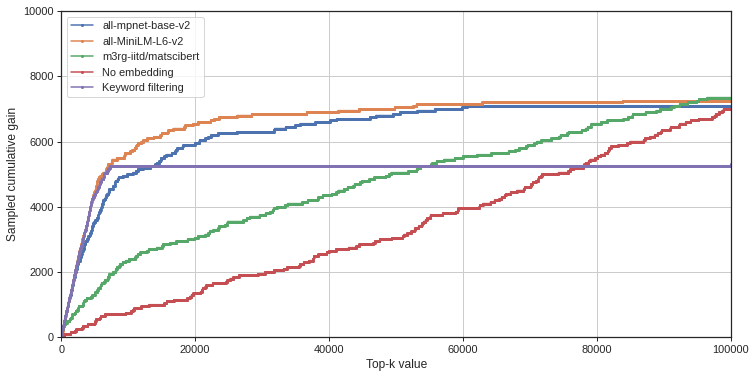

In [19]:
import numpy as np
import matplotlib.pyplot as plt

keywords = {"al2o3", "fe2o3", "cao", "mgo", "so3", "tio2", "mno", "k2o", "na2o", "loi", "loss of ignition", "ignition loss"}
responses_cleaned = []



  

        
def plot_cumulative_ones(responses, model_name):
    # Extract relevance scores from responses
    relevance_scores = []
    for (score, table, doi) in responses:
        # Check if score is a list
        if isinstance(score, list):
            # Further check if the list is non-empty and contains an integer
            if score and isinstance(score[0], int):
                relevance_scores.append(score[0])
            else:
                print("Found a list, but it's either empty or does not contain an integer:", score)
                relevance_scores.append(0)
        # Check if score is an integer
        elif isinstance(score, int):
            relevance_scores.append(score)
        else:
            print("Score is neither a list nor an integer:", score)
            relevance_scores.append(0)
    


    
    
    # Calculate cumulative sum
    cumulative_ones = np.cumsum(relevance_scores)
    # Prepare x-values for plotting (every 50th document)
    x_values = np.arange(0, len(cumulative_ones) * 50, 50)
    
    # Plot cumulative counts
    plt.plot(x_values, cumulative_ones*50, label=model_name,marker='o',markersize=2)

# Loop through the models and plot
plt.figure(figsize=(12, 6))


# Define your models and corresponding directories
models = [
    {"name": "all-mpnet-base-v2", "directory": "data/chroma/etmpnet", "type": "sentence-transformer"},
    {"name": "all-MiniLM-L6-v2", "directory": "data/chroma/etsminilm", "type": "sentence-transformer"},
    {"name": "m3rg-iitd/matscibert", "directory": "data/chroma/etscibert", "type": "huggingface", "device": "cuda"},
    {"name": "No embedding", "directory": "", "type": ""},
    #{"name": "Okapi BM25 + all-MiniLM-L6-v2", "directory": "", "type": ""},

]

for model_info in models:
    model_name = model_info['name'].replace("/", "_").replace("\\", "_")
    filename = f"responses_{model_name}_sampled.json"

    if os.path.exists(filename):
        with open(filename, 'r') as file:
            responses = json.load(file)
        for score, table, doi in responses:
        # Check if any keyword is in table (case insensitive)
            if any(keyword in str(table).lower() for keyword in keywords):
                responses_cleaned.append((score, table, doi))

        # Determine the number of elements to pad
        num_to_pad = len(responses) - len(responses_cleaned)

        # Create padding tuples, here using (None, None, None) as placeholders
        padding = [(0, 0, 0) for _ in range(num_to_pad)]

        # Extend responses_cleaned with the padding
        responses_cleaned.extend(padding)        
        
        plot_cumulative_ones(responses, model_info['name'])
        if model_info['name']=="No embedding":
            plot_cumulative_ones(responses_cleaned, "Keyword filtering")
    else:
        print(f"File {filename} does not exist.")

        
        
        


        
        
plt.xlim(0, 100000)
plt.ylim(0, 10000)
plt.xlabel('Top-k value')
plt.ylabel('Sampled cumulative gain')
plt.legend(loc=2)
plt.grid(True)

plt.savefig('filename.pdf')
!pdftoppm -png -r 300 filename.pdf filename


plt.show()
